Link Dashboard: bit.ly/HungariaDashboard

transactions2 (transactions setelah explode): https://drive.google.com/file/d/1vJyrsCvRoCeGDSyBRBjEKLw5PLyvgcO5/view?usp=sharing

# **Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime as dt
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import  precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb

Mounted at /content/drive


In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import squarify

# **Import Datasets**

In [ ]:
#Click Stream
click_stream = pd.read_csv('/content/drive/My Drive/Mockup Datasets/click_stream.csv')

#Customer
customer = pd.read_csv('/content/drive/My Drive/Mockup Datasets/customer.csv')

#Product
prod_col = ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour',
            'season', 'year', 'usage', 'productDisplayName', 'x', 'y']
product = pd.read_csv('/content/drive/My Drive/Mockup Datasets/product.csv', names = prod_col, header = None)
product.drop(index = 0, inplace = True)
product.reset_index().drop('index', axis = 1, inplace = True)
product['productDisplayName'] = product[['productDisplayName', 'x', 'y']].apply(lambda x: x.str.cat(sep = ''), axis=1)
product.drop(['x', 'y'], axis = 1, inplace = True)

#Transactions
transactions = pd.read_csv('/content/drive/My Drive/Mockup Datasets/transactions.csv')

In [ ]:
click_stream.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [ ]:
customer.head()

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [ ]:
product.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
1,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
2,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
3,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
4,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
5,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [ ]:
transactions.head()

,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753


Karena terdapat kolom metadata pada dataset click_stream dan transactions, maka perlu diexplode. Pada kolom event_metadata untuk dataset click_stream, missing values perlu dipisahkan terlebih dahulu.

Berikut cara explode dataset transactions:
- transactions['product_metadata'] = transactions['product_metadata'].apply(ast.literal_eval)
- transactions = transactions.explode('product_metadata')
- transactions[list(transactions['product_metadata'].head(1).tolist()[0].keys())] = transactions['product_metadata'].apply(
    lambda x: pd.Series([x[key] for key in x.keys()])
    )
- transactions.to_csv('transactions2.csv', index = False)

Karena waktu untuk memproses explode ini lama sekali, maka kami simpan ke file csv baru.

transactions2: https://drive.google.com/file/d/1vJyrsCvRoCeGDSyBRBjEKLw5PLyvgcO5/view?usp=sharing


In [ ]:
#Transactions setelah explode
transactions2 = pd.read_csv('/content/drive/My Drive/transactions2.csv')

In [ ]:
#Melihat informasi pada tiap dataset
info = [customer, product, transactions2]

print('click_stream :\n', click_stream.shape)
print(click_stream.isnull().sum())

for i in info:
  i.info()

click_stream :
 (12833602, 6)
session_id              0
event_name              0
event_time              0
event_id                0
traffic_source          0
event_metadata    8544062
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null 

# **EDA & Feature Engineering**

## **Datasets**

### **Click Stream**

In [ ]:
#Add columns
click_stream['event_year'] = pd.to_datetime(click_stream['event_time']).dt.year
click_stream['event_month'] = pd.to_datetime(click_stream['event_time']).dt.month

Text(0.5, 1.0, 'Top Event')

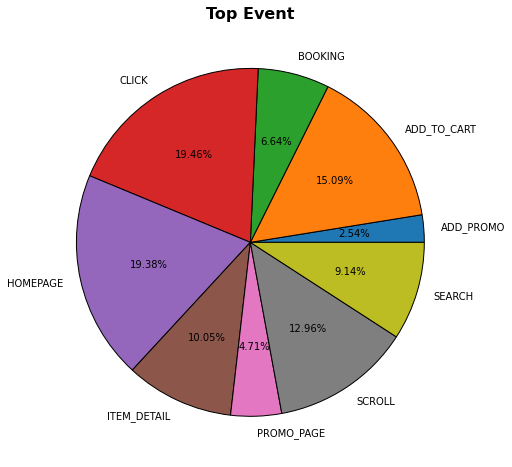

In [ ]:
top_event = click_stream.groupby('event_name')['event_id'].count().reset_index()
top_event = top_event.rename(columns = {'event_id' : 'total_event'})

plt.figure(figsize = (8, 8))
plt.pie(data = top_event, x = 'total_event', labels = 'event_name', autopct = '%1.2f%%', wedgeprops = {'edgecolor' : 'black'})
plt.title('Top Event', fontweight = 'bold', fontdict = {'fontsize' : 16})

Terdapat 9 event yang bisa dilakukan pelanggan. Dari 12833602 event, event yang paling banyak dilakukan pertama adalah click (19.5%), kedua adalah homepage (19.4%), dan ketiga adalah add to cart (15.1%).

Text(0.5, 1.0, 'Comparison between Specific Events (Jan - Jul)')

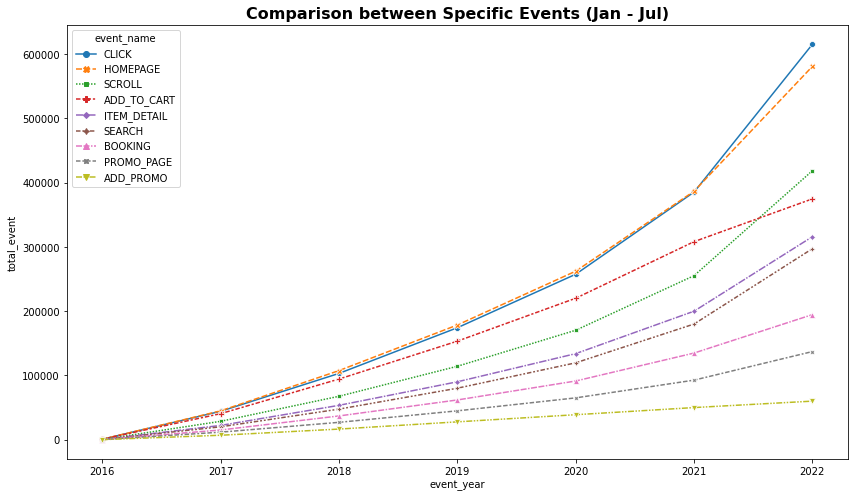

In [ ]:
month17 = [1, 2, 3, 4, 5, 6, 7]
event = click_stream['event_name'].unique()

top_event_year = click_stream[click_stream['event_month'].isin(month17)]
top_event_year = top_event_year[top_event_year['event_name'].isin(event)].groupby(['event_year', 'event_name'])['event_id'].count().reset_index()
top_event_year = top_event_year.rename(columns = {'event_id' : 'total_event'})
top_event_year = top_event_year.sort_values('total_event', ascending = False)

plt.figure(figsize = (14, 8))
sns.lineplot(data = top_event_year, x = 'event_year', y = 'total_event', hue = 'event_name', style = 'event_name', markers = True)
plt.title('Comparison between Specific Events (Jan - Jul)', fontweight = 'bold', fontdict = {'fontsize' : 16})

Dari tahun 2016 sampai 2021, tiap eventnya selalu mengalami peningkatan. Untuk

1.   List item
2.   List item

tahun 2022 menurun karena pada datanya baru mencapai bulan juli 2022. Peningkatan yang sangat besar terjadi pada tahun 2020 dan 2021. Kemungkinan besar hal tersebut dapat terjadi karena banyak pelanggan yang aktif dan gabung pada masa COVID-19.

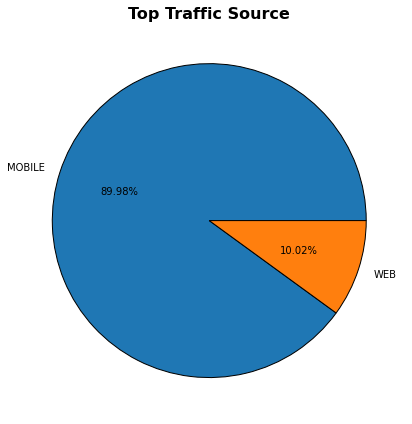

In [ ]:
top_traffic = click_stream.groupby('traffic_source')['event_id'].count().reset_index()
top_traffic = top_traffic.rename(columns = {'event_id' : 'total_traffic'})

plt.figure(figsize = (6, 6))
plt.pie(data = top_traffic, x = 'total_traffic', labels = 'traffic_source', autopct = '%1.2f%%', wedgeprops = {'edgecolor' : 'black'})
plt.title('Top Traffic Source', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.tight_layout()

Terdapat 2 traffic source saja yaitu melalui mobile dan web. Berdasarkan chart diatas, traffic terbanyak melalui penggunaan mobile dengan persentase 90% atau sebanyak 11.548.304.

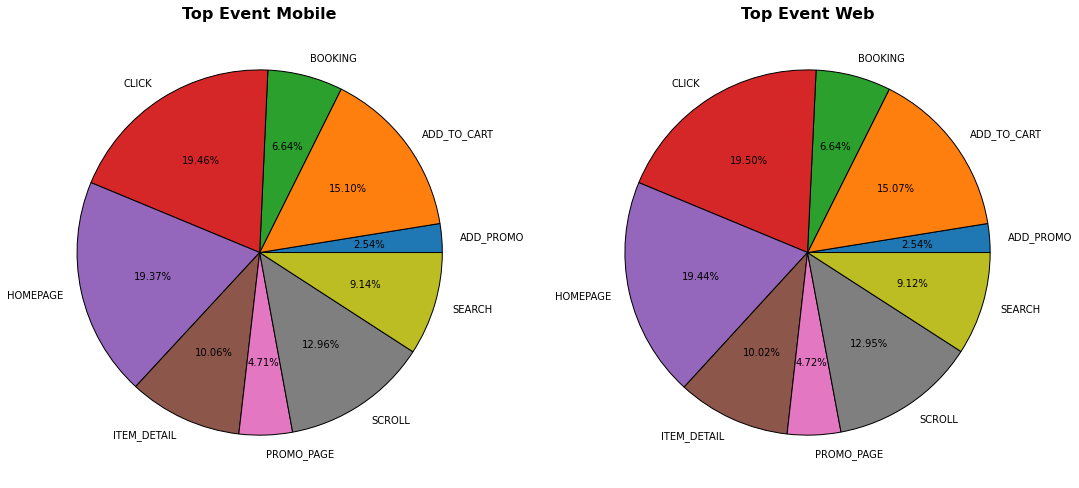

In [ ]:
top_event_mobile = click_stream[click_stream['traffic_source'] == 'MOBILE'].groupby('event_name')['event_id'].count().reset_index()
top_event_mobile = top_event_mobile.rename(columns = {'event_id' : 'total_event'})

top_event_web = click_stream[click_stream['traffic_source'] == 'WEB'].groupby('event_name')['event_id'].count().reset_index()
top_event_web = top_event_web.rename(columns = {'event_id' : 'total_event'})

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 10))

ax1.pie(data = top_event_mobile, x = 'total_event', labels = 'event_name', autopct = '%1.2f%%', wedgeprops = {'edgecolor':'black'})
ax1.set_title('Top Event Mobile', fontweight = 'bold', size = 16)

ax2.pie(data = top_event_web, x = 'total_event', labels = 'event_name', autopct = '%1.2f%%', wedgeprops = {'edgecolor':'black'})
ax2.set_title('Top Event Web', fontweight = 'bold', size = 16)

plt.show()

Baik dari traffic source mobile dan web memiliki event yang sama.

Text(0.5, 1.0, 'Top 10 Search Keywords')

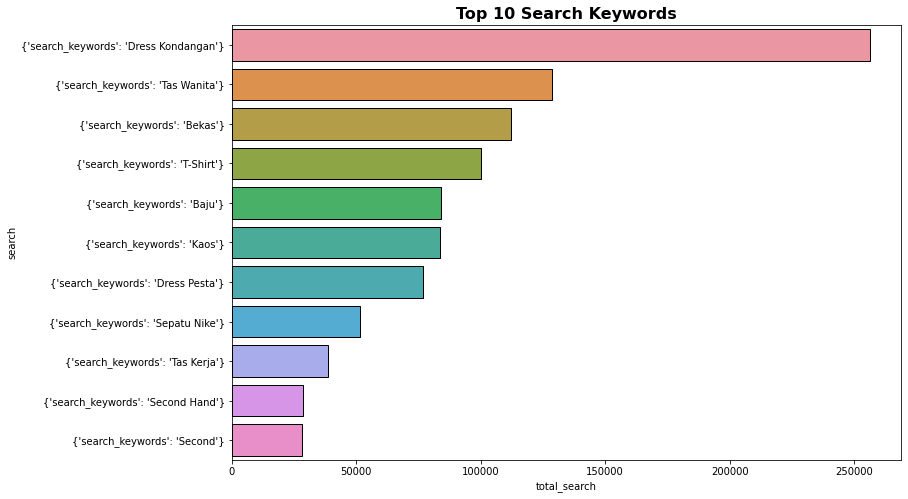

In [ ]:
top_search = click_stream[click_stream['event_name'] == 'SEARCH']['event_metadata'].value_counts()[:11].reset_index()
top_search = top_search.rename(columns = {'index' : 'search', 'event_metadata' : 'total_search'})

plt.figure(figsize = (12, 8))
sns.barplot(data = top_search, x = 'total_search', y = 'search', edgecolor = 'black')
plt.title('Top 10 Search Keywords', fontweight = 'bold', fontdict = {'fontsize' : 16})

Grafik diatas menjelaskan mengenai keywords yang paling banyak dicari dari tahun 2016 sampai 2022. Pencarian terbanyak yang dicari oleh pelanggan adalah dress kondangan dengan total 256.194. Pencarian terbanyak kedua adalah tas wanita dengan total 128.790. Dan ketiga pencarian terbanyak adalah bekas dengan total 112.269. Grafik ini dapat menjadi saran bagi fashion campus untuk menyiapkan produk sesuai pencarian diatas karena banyak pelanggan yang mencari.

Text(0.5, 1.0, 'Top 3 Search Keywords Every Year')

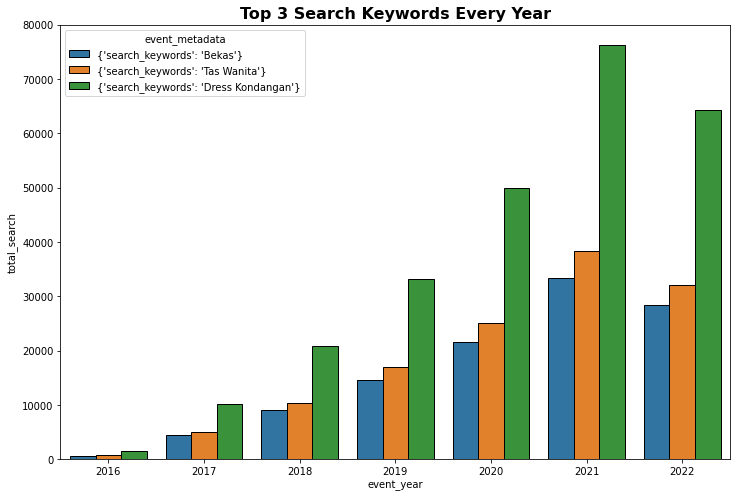

In [ ]:
top_search_year = click_stream[click_stream['event_name'] == 'SEARCH'].groupby(['event_year', 'event_metadata'])['event_id'].count().reset_index()
top_search_year = top_search_year.rename(columns = {'event_id' : 'total_search'})
top_search_year = top_search_year[top_search_year['event_metadata'].isin(top_search['search'][:3])]
top_search_year = top_search_year.sort_values('total_search', ascending = True)

plt.figure(figsize = (12, 8))
sns.barplot(data = top_search_year, x = 'event_year', y = 'total_search', hue = 'event_metadata', edgecolor = 'black')
plt.title('Top 3 Search Keywords Every Year', fontweight = 'bold', fontdict = {'fontsize' : 16})

Berikut top 3 pencarian terbanyak dari tahun 2016 hingga 2022. Pencarian dress kondangan mengalami peningkatan yang besar tiap tahunnya terutama pada tahun 2021. Diperkirakan tahun 2022 pencarian dress kondangan bisa lebih banyak lagi karena pada data click stream baru mencapai bulan juli 2022.

In [ ]:
# clickstream different event_name with column name (event) and (jumlah_total)
events = pd.DataFrame(click_stream['event_name'].value_counts().reset_index().rename(columns={'index':'event', 'event_name':'jumlah_total'}))

# add percentage two digit after comma (persentase_jumlah_total)
# events['persentase_jumlah_total'] = events['jumlah_total'].apply(lambda x: "{:.2f}%".format(x/df_events['jumlah_total'].sum()*100))
events['persentase_jumlah_total'] = events['jumlah_total'].apply(lambda x: "{:.2f}%".format(x/events['jumlah_total'].sum()*100))

# add count customer_id with transactions (jumlah_customer)
events['jumlah_customer'] = events['event'].apply(lambda x: transactions.merge(click_stream[click_stream['event_name'] == x] , how = 'inner', on = 'session_id')['customer_id'].nunique())

# add percentage two digit after comma (persentase_jumlah_customer)
events['persentase_jumlah_customer'] = events['jumlah_customer'].apply(lambda x: "{:.2f}%".format(x/customer['customer_id'].count()*100))

events

,event,jumlah_total,persentase_jumlah_total,jumlah_customer,persentase_jumlah_customer
0,CLICK,2498038,19.46%,46733,46.73%
1,HOMEPAGE,2487126,19.38%,50704,50.70%
2,ADD_TO_CART,1937157,15.09%,50704,50.70%
3,SCROLL,1663571,12.96%,44452,44.45%
4,ITEM_DETAIL,1290396,10.05%,43827,43.83%
5,SEARCH,1173266,9.14%,42165,42.16%
6,BOOKING,852582,6.64%,50704,50.70%
7,PROMO_PAGE,604931,4.71%,39064,39.06%
8,ADD_PROMO,326535,2.54%,38879,38.88%


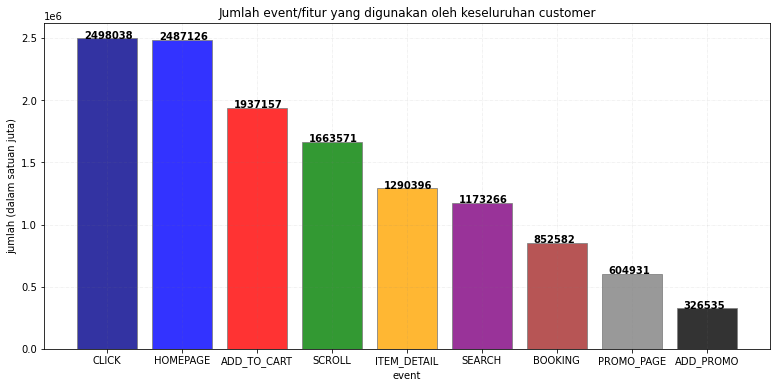

In [ ]:
# plot jumlah total 'event' clicked
fig, ax = plt.subplots(figsize = (13, 6))

plt.bar(events['event'], events['jumlah_total'], color = ['darkblue', 'blue', 'red', 'green', 'orange', 'purple', 'brown', 'grey', 'black'], linewidth = 1,
        edgecolor = 'gray', alpha = 0.8)


# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_x()+0.089, i.get_height()+0.2, str(round((i.get_height()), 2)), fontsize = 10, fontweight ='bold', color ='black')

# Add x, y gridlines
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

plt.title('Jumlah event/fitur yang digunakan oleh keseluruhan customer')
plt.xlabel('event')
plt.ylabel('jumlah (dalam satuan juta)')
# plt.xticks(rotation=90)

plt.show()

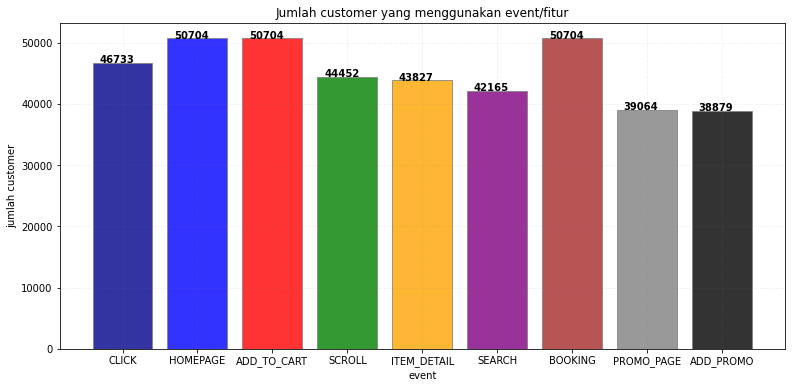

In [ ]:
# plot customer
fig, ax = plt.subplots(figsize = (13, 6))

plt.bar(events['event'], events['jumlah_customer'], color = ['darkblue', 'blue', 'red', 'green', 'orange', 'purple', 'brown', 'grey', 'black'], linewidth = 1,
        edgecolor = 'gray',  alpha = 0.8)


# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_x()+0.089, i.get_height()+0.2, str(round((i.get_height()), 2)), fontsize = 10, fontweight ='bold', color ='black')

# Add x, y gridlines
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

plt.title('Jumlah customer yang menggunakan event/fitur')
plt.xlabel('event')
plt.ylabel('jumlah customer')
# plt.xticks(rotation=90)

plt.show()

Jumlah pelanggan yang melakukan booking hanya 1/2 dari keseluruhan pelanggan.

In [ ]:
event_add_to_cart = click_stream[click_stream['event_name'] == 'ADD_TO_CART']
total_add_to_cart = event_add_to_cart.groupby(['session_id'])['event_name'].count().reset_index().rename(columns = {'event_name' : 'total_add_to_cart'})

event_booking = click_stream[click_stream['event_name'] == 'BOOKING']
total_booking = event_booking.groupby(['session_id'])['event_name'].count().reset_index().rename(columns = {'event_name' : 'total_booking'})

total_checkout = total_add_to_cart.merge(right = total_booking, how = 'outer', on = 'session_id')
customer_transaction = customer[['customer_id']].merge(right = transactions[['customer_id', 'session_id']], how = 'outer', on = 'customer_id')
checkout_rate =  customer_transaction.merge(right = total_checkout, how = 'right', on = 'session_id')
checkout_rate = checkout_rate.groupby(['customer_id']).agg({'total_add_to_cart' : 'sum', 'total_booking' : 'sum'}).reset_index()
checkout_rate = checkout_rate.merge(right = customer[['customer_id', 'gender', 'home_location']], how = 'outer', on = 'customer_id')
checkout_rate = checkout_rate.fillna(0)

In [ ]:
checkout_rate_gender = checkout_rate.groupby(['gender']).agg({'customer_id' : 'count', 'total_add_to_cart' : 'sum', 'total_booking' : 'sum'}).reset_index().rename(columns = {'customer_id' : 'total_customer'})
checkout_rate_gender['checkout_rate'] = checkout_rate_gender['total_booking'] / checkout_rate_gender['total_add_to_cart']
checkout_rate_gender

,gender,total_customer,total_add_to_cart,total_booking,checkout_rate
0,F,64230,1206202.0,543509.0,0.450595
1,M,35770,688329.0,309073.0,0.449019


Pelanggan wanita jumlahnya lebih banyak dan checkout ratenya lebih besar dari pria. Sepertinya pria banyak tidak jadi membeli karena harga (?).

In [ ]:
checkout_rate_home_location = checkout_rate.groupby(['home_location']).agg({'customer_id' : 'count', 'total_add_to_cart' : 'sum', 'total_booking' : 'sum'}).reset_index().rename(columns = {'customer_id' : 'total_customer'})
checkout_rate_home_location['checkout_rate'] = checkout_rate_home_location['total_booking'] / checkout_rate_home_location['total_add_to_cart']
checkout_rate_home_location = checkout_rate_home_location.sort_values(by = 'checkout_rate', ascending = False)
checkout_rate_home_location

,home_location,total_customer,total_add_to_cart,total_booking,checkout_rate
20,Nusa Tenggara Timur,587,9961.0,5004.0,0.502359
21,Papua,753,14670.0,6904.0,0.470620
15,Kepulauan Riau,1902,38122.0,17843.0,0.468050
29,Sumatera Barat,1346,23894.0,11139.0,0.466184
13,Kalimantan Tengah,4091,80505.0,37249.0,0.462692
18,Maluku Utara,368,7231.0,3334.0,0.461070
27,Sulawesi Tenggara,246,3847.0,1768.0,0.459579
3,Banten,377,7203.0,3284.0,0.455921
31,Sumatera Utara,1004,19289.0,8766.0,0.454456
8,Jawa Barat,11486,222838.0,101244.0,0.454339


Lokasi rumah di pulau Jawa seperti Jakarta, Jawa Barat, dll memiliki pelanggan hingga 10ribuan namun checkout ratenya tergolong rendah. Sepertinya karena banyak persaingan, pelanggan lebih memilih berbelanja di tempat lain.

### **Customer**

In [ ]:
#Add columns

#Region
def region(x):
  if x in ['Papua', 'Papua Barat']:
    return 'Papua'
  elif x in ['Maluku', 'Maluku Utara']:
    return 'Kepulauan Maluku'
  elif x in ['Sulawesi Tengah', 'Gorontalo', 'Sulawesi Utara', 'Sulawesi Selatan', 'Sulawesi Tenggara', 'Sulawesi Barat']:
    return 'Sulawesi'
  elif x in ['Bali', 'Nusa Tenggara Timur', 'Nusa Tenggara Barat']:
    return 'Kepulauan Nusa Tenggara'
  elif x in ['Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Selatan', 'Kalimantan Barat']:
    return 'Kalimantan'
  elif x in ['Banten', 'Jawa Tengah', 'Jawa Timur', 'Jakarta Raya', 'Yogyakarta', 'Jawa Barat']:
    return 'Jawa'
  else:
    return 'Sulawesi'
customer['home_region'] = customer['home_location'].apply(region)

#Age
customer['age'] = pd.to_datetime(transactions2['created_at'].max()).year - pd.to_datetime(customer['birthdate']).dt.year

#Age Range
def age_range(x):
  if x < 15:
    return '< 15'
  elif (x >= 15) & (x <= 35):
    return '15 - 35'
  else:
    return '> 35'
customer['age_range'] = customer['age'].apply(age_range)

#Account Length
customer['account_length'] = (pd.to_datetime('20220731', format = '%Y-%m-%d') - pd.to_datetime(customer['birthdate'])).astype('timedelta64[M]').astype('int')

#First Join Year
customer['first_join_year'] = pd.to_datetime(customer['first_join_date']).dt.year

**Demography**

Text(0.5, 1.0, 'Age Distribution')

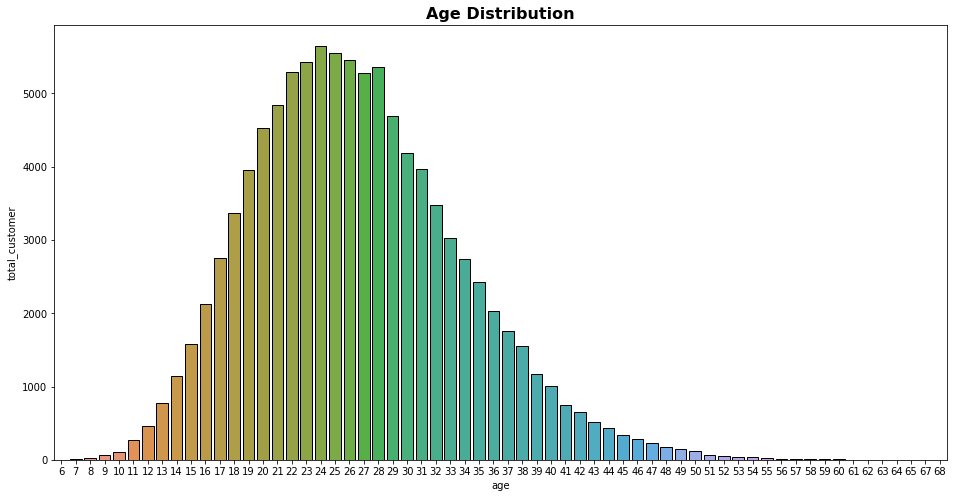

In [ ]:
customer_age = customer['age'].value_counts().reset_index().rename(columns = {'index' : 'age', 'age' : 'total_customer'})

plt.figure(figsize = (16, 8))
sns.barplot(data = customer_age, x = 'age', y = 'total_customer', edgecolor = 'black')
plt.title('Age Distribution', fontweight = 'bold', fontdict = {'fontsize' : 16})

Rentang umur pelanggan dari umur 6 hingga 68. Pelanggan terbanyak berada di umur 24 tahun.

In [ ]:
print('Total customers aged 24:')
print(customer[customer['age'] == 24]['customer_id'].count())

percentage_24 = customer[customer['age'] == 24]['customer_id'].count() / customer.shape[0]
print('Percentage:')
print(f'{round(100 * percentage_24, 2)}%')

Total customers aged 24:
5653
Percentage:
5.65%


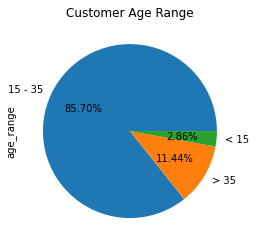

In [ ]:
customer['age_range'].value_counts().plot(kind = 'pie', title = 'Customer Age Range', autopct = '%1.2f%%')

Mayoritas rentang umur pelanggan Fashion Campus berkisar diantara umur 15 sampai 35.

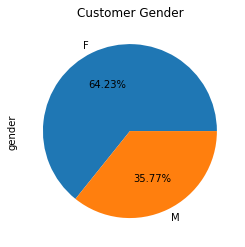

In [ ]:
customer['gender'].value_counts().plot(kind = 'pie', title = 'Customer Gender', autopct = '%1.2f%%')

Mayoritas pelanggan dari Fashion Campus bergender wanita.

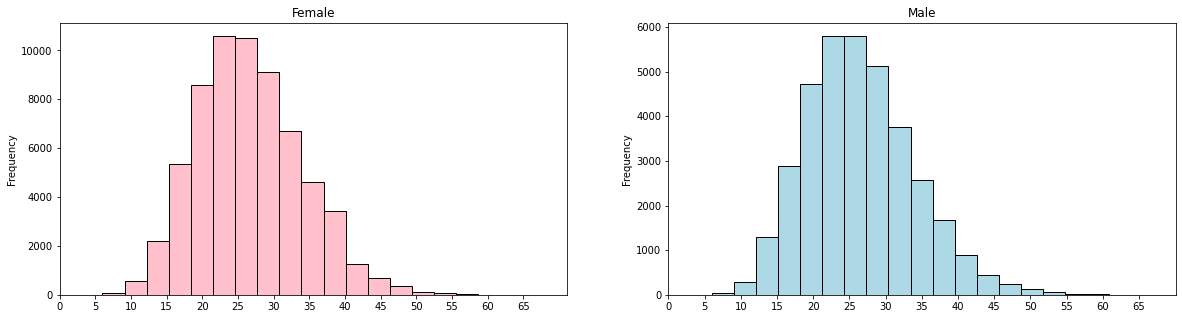

In [ ]:
# Age Group Distribution per gender
f,ax=plt.subplots(1,2,figsize=(20,5))
customer[customer['gender']=="F"].age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='pink')
ax[0].set_title('Female')
x1=list(range(0,70,5))
ax[0].set_xticks(x1)
customer[customer['gender']=="M"].age.plot.hist(ax=ax[1],color='lightblue',bins=20,edgecolor='black')
ax[1].set_title('Male')
x2=list(range(0,70,5))
ax[1].set_xticks(x2)
plt.show()

Pelanggan wanita dan pria terbanyak berusia 20-30 tahun. Namun, pada rentang tersebut wanita lebih banyak yaitu >10.000, sedangkan pria <6.000

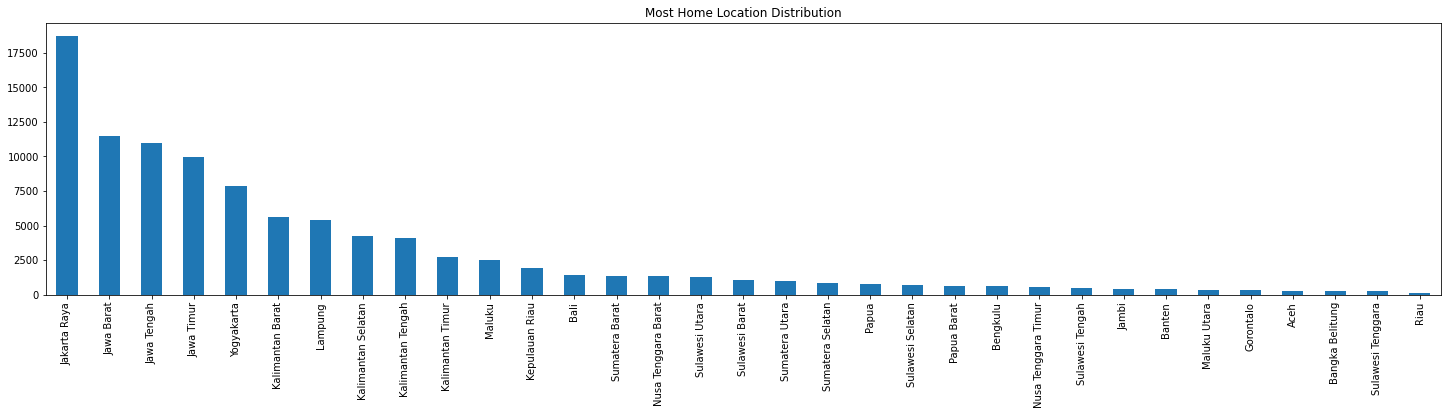

In [ ]:
customer['home_location'].value_counts().plot(kind = 'bar', figsize = (25,5), title = 'Most Home Location Distribution')

Lokasi dengan pelanggan terbanyak berada di provinsi DKI Jakarta. Jika diteliti lebih lanjut pelanggan terbanyak berada di pulau Jawa.

Sedangkan lokasi dengan pelanggan paling sedikit berada di provinsi Riau.

**Device**

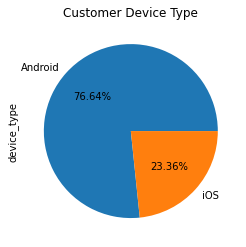

In [ ]:
customer['device_type'].value_counts().plot(kind = 'pie', title = 'Customer Device Type', autopct = '%1.2f%%')

Mayoritas pelanggan menggunakan OS android.

**New Customer Every Year**

Text(0.5, 1.0, 'New Customer Every Year (Jan-Jul)')

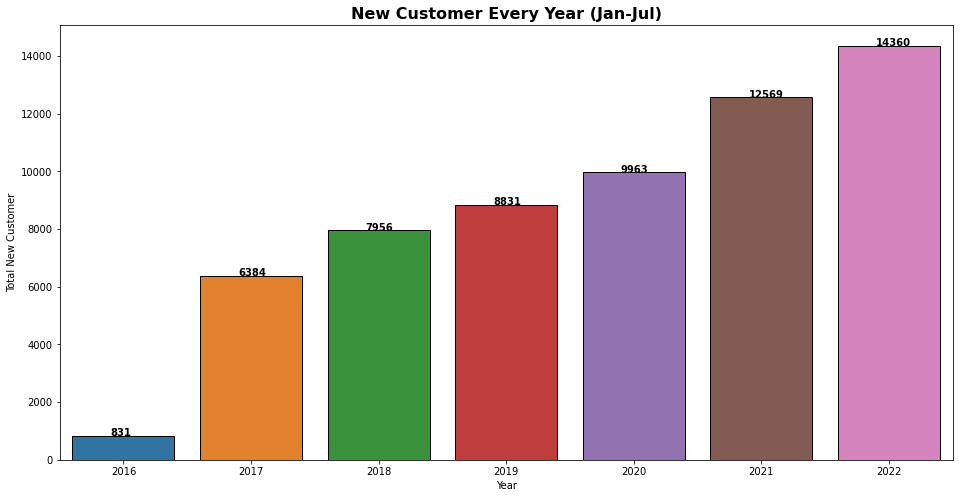

In [ ]:
new_customer_year = customer[pd.DatetimeIndex(customer['first_join_date']).month.isin(month17)]

plt.figure(figsize = (16, 8))
ax = sns.countplot(data = new_customer_year, x = 'first_join_year', edgecolor = 'black')
for i in ax.patches:
    plt.text(i.get_x()+0.3, i.get_height()+0.5, str(round((i.get_height()), 2)), fontsize = 10, fontweight ='bold', color ='black')
plt.xlabel('Year')
plt.ylabel('Total New Customer')
plt.title('New Customer Every Year (Jan-Jul)', fontweight = 'bold', fontdict = {'fontsize' : 16})

Jumlah pelanggan baru dari tahun ke tahun (bulan 1 - 7) mengalami peningkatan yang besar, terutama saat pandemi COVID-19.

In [ ]:
# plt.figure(figsize = (16, 8))
# ax = sns.countplot(data = customer, x = 'first_join_year', edgecolor = 'black')
# for i in ax.patches:
#     plt.text(i.get_x()+0.3, i.get_height()+0.5, str(round((i.get_height()), 2)), fontsize = 10, fontweight ='bold', color ='black')
# plt.xlabel('Year')
# plt.ylabel('Total New Customer')
# plt.title('New Customer Every Year', fontweight = 'bold', fontdict = {'fontsize' : 16})

Jumlah user baru ketika COVID-19 meningkat pesat

### **Product**

In [ ]:
#Rename columns
product = product.rename(columns = {'gender' : 'productGender'})

product['id'] = product['id'].astype(int)

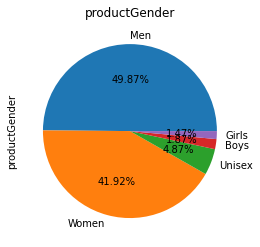

In [ ]:
product['productGender'].value_counts().plot(kind = 'pie', title = 'productGender', autopct = '%1.2f%%')

Product Gender terbanyak adalah Men lalu Women.

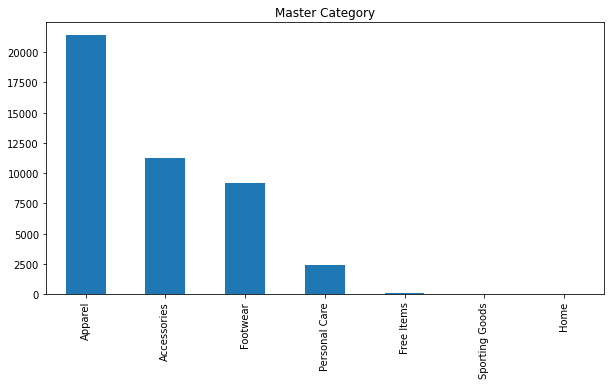

In [ ]:
product['masterCategory'].value_counts().plot(kind='bar', figsize=(10,5), title = "Master Category")

Mayoritas kategori produk yang tersedia adalah apparel.

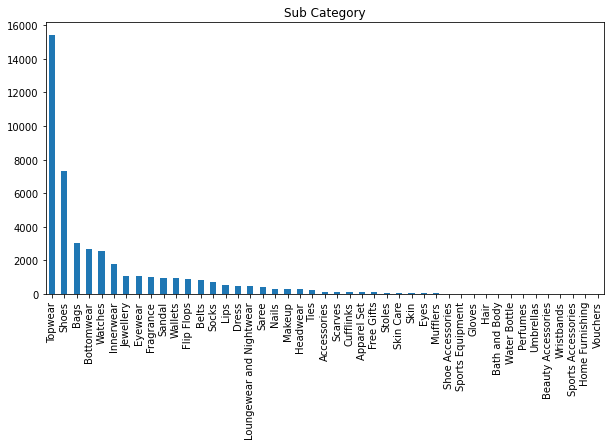

In [ ]:
product['subCategory'].value_counts().plot(kind='bar', figsize=(10,5), title = "Sub Category")

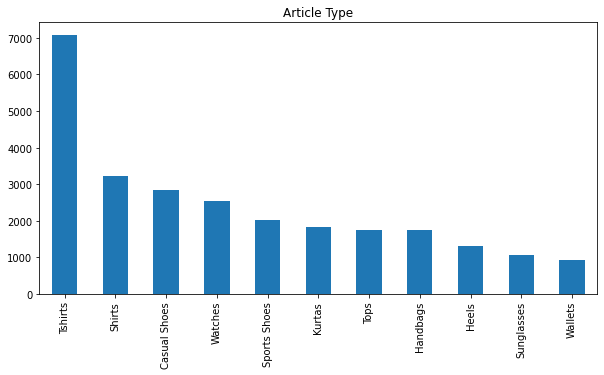

In [ ]:
product['articleType'].value_counts()[:11].plot(kind='bar', figsize=(10,5), title = "Article Type")

Text(0.5, 1.0, 'Products Percentage by Usage')

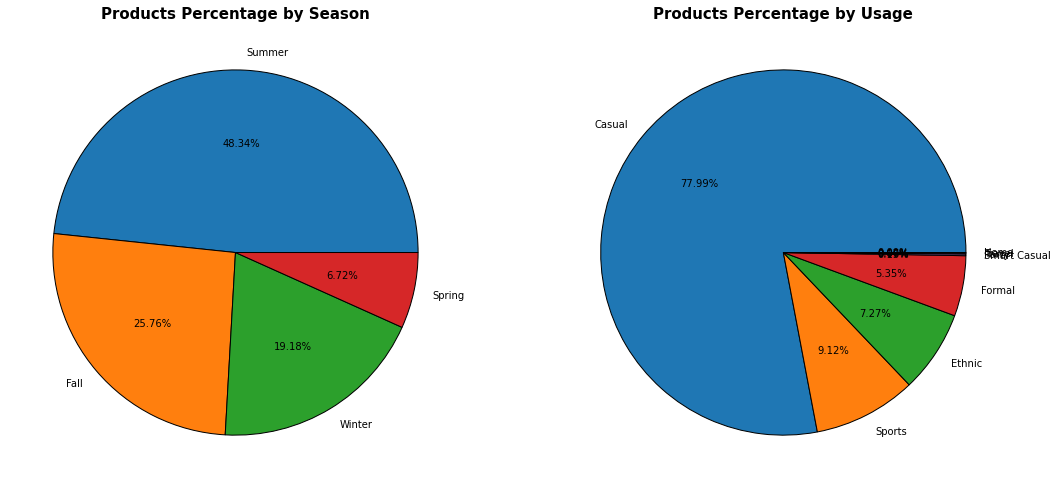

In [ ]:
product_season = product['season'].value_counts().reset_index().rename(columns = {'index' : 'season', 'season' : 'total_product'})
product_usage = product['usage'].value_counts().reset_index().rename(columns = {'index' : 'usage', 'usage' : 'total_product'})

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 10))

ax1.pie(data = product_season, x = 'total_product', labels = 'season', autopct = '%1.2f%%', wedgeprops = {'edgecolor':'black'})
ax1.set_title('Products Percentage by Season', fontweight = 'bold', size = 15)

ax2.pie(data = product_usage, x = 'total_product', labels = 'usage', autopct = '%1.2f%%', wedgeprops = {'edgecolor':'black'})
ax2.set_title('Products Percentage by Usage', fontweight = 'bold', size = 15)

Text(0.5, 1.0, 'Products Percentage by Year')

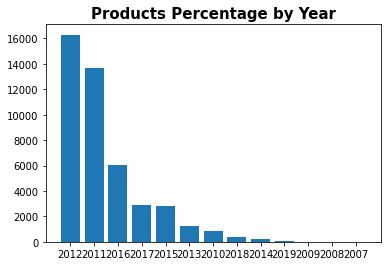

In [ ]:
product_year = product['year'].value_counts().reset_index().rename(columns = {'index' : 'year', 'year' : 'total_product'})

plt.bar(data = product_year, x = 'year', height = 'total_product')
plt.title('Products Percentage by Year', fontweight = 'bold', size = 15)

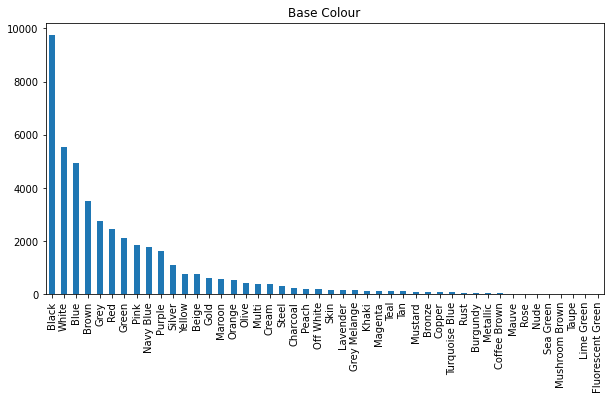

In [ ]:
product['baseColour'].value_counts().plot(kind='bar', figsize=(10,5), title = "Base Colour")

### **Transactions**

In [ ]:
#Add columns

#Month Year Order
transactions2['created_at'] = transactions2['created_at'].astype('datetime64')
transactions2['order_year'] = transactions2['created_at'].dt.year
transactions2['order_month_year'] = transactions2['created_at'].dt.month_name()

#Shipment Time
transactions2['shipment_time'] = transactions2['shipment_date_limit'].astype('datetime64') - transactions2['created_at'].astype('datetime64')
transactions2['shipment_time'] = transactions2['shipment_time'].astype('timedelta64[D]')

In [ ]:
transactions_no_duplicate = transactions2.drop_duplicates('booking_id')

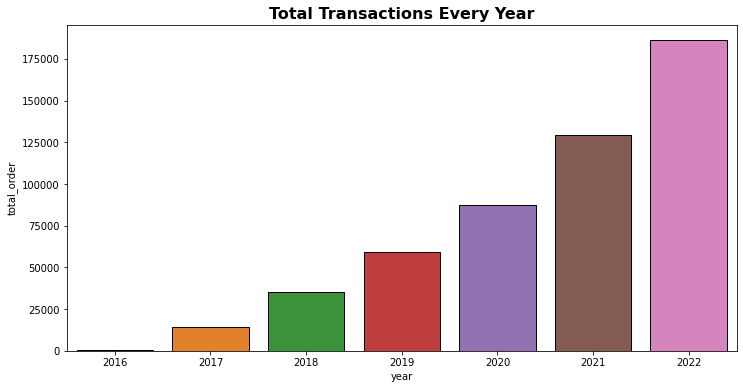

In [ ]:
transactions['year'] = pd.to_datetime(transactions['created_at']).dt.year
transactions['month'] = pd.to_datetime(transactions['created_at']).dt.month

month17 = [1, 2, 3, 4, 5, 6, 7]

transactions_month17 = transactions[transactions['month'].isin(month17)]
transactions_year = transactions_month17[transactions_month17['payment_status'] == 'Success'].groupby('year')['created_at'].count().reset_index()
transactions_year = transactions_year.rename(columns = {'created_at' : 'total_order'})

plt.figure(figsize = (12, 6))
sns.barplot(data = transactions_year, x = 'year', y = 'total_order', edgecolor = 'black')
plt.title('Total Transactions Every Year', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

Total transaksi (bulan 1 - 7) terus meningkat pesat, terutama ketika pandemi COVID-19.

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


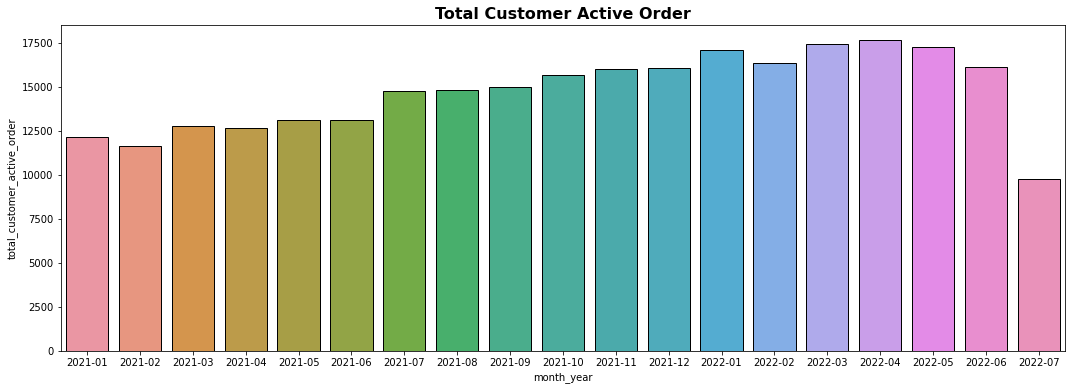

In [ ]:
transactions['month_year'] = pd.to_datetime(transactions['created_at']).dt.to_period('M')
transactions_2021 = transactions[transactions['created_at'] >= '2021-01-01']
transactions_2021 = transactions_2021.drop_duplicates(['customer_id', 'month_year'])

transactions_customer = transactions_2021[transactions_2021['payment_status'] == 'Success'].groupby('month_year')['created_at'].count().reset_index()
transactions_customer = transactions_customer.rename(columns = {'created_at' : 'total_customer_active_order'})

plt.figure(figsize = (18, 6))
sns.barplot(data = transactions_customer, x = 'month_year', y = 'total_customer_active_order', edgecolor = 'black')
plt.title('Total Customer Active Order', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

Bulan 7 2022, jumlah pelanggan yang aktif melakukan order mengalami penurunan yang cukup banyak dibandingkan bulan-bulan sebelumnya.

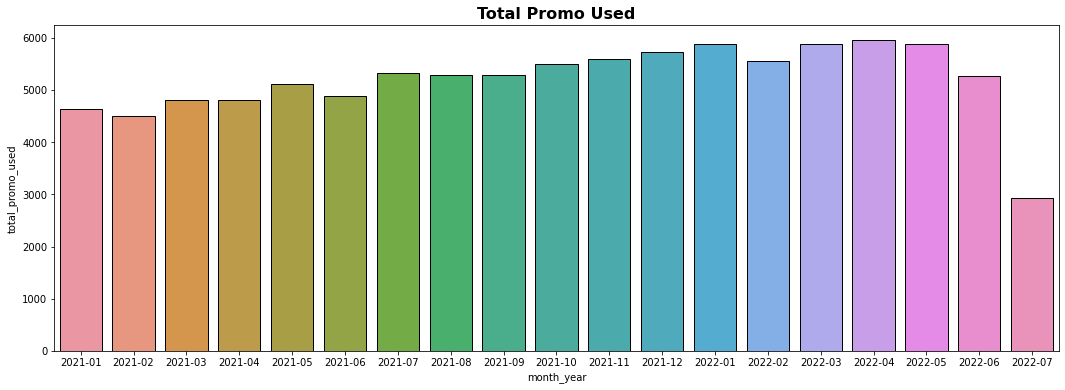

In [ ]:
transactions_2021_promo = transactions_2021[transactions_2021['promo_code'].isnull() == False]

transactions_promo_year = transactions_2021_promo[transactions_2021_promo['payment_status'] == 'Success'].groupby('month_year')['created_at'].count().reset_index()
transactions_promo_year = transactions_promo_year.rename(columns = {'created_at' : 'total_promo_used'})

plt.figure(figsize = (18, 6))
sns.barplot(data = transactions_promo_year, x = 'month_year', y = 'total_promo_used', edgecolor = 'black')
plt.title('Total Promo Used', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

Promo yang digunakan pada bulan 7 2022 juga mengalami penurunan hampir setengahnya dari bulan 6 2022. Sepertinya karena promo yang tersedia sedikit, maka banyak pelanggan yang tidak melakukan order lagi.

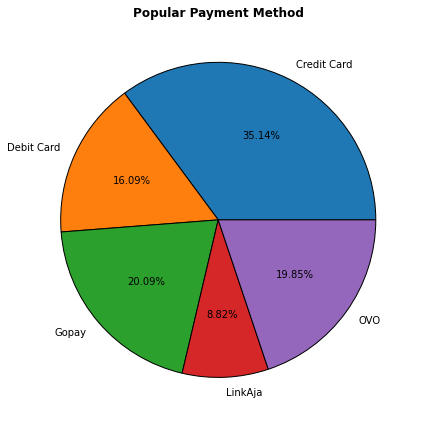

In [ ]:
payment_method = transactions[transactions['payment_status'] == 'Success'].groupby('payment_method')['created_at'].count().reset_index()
payment_method = payment_method.rename(columns = {'created_at' : 'total_order'})

plt.figure(figsize = (6, 6))
plt.pie(data = payment_method, x = 'total_order', labels = 'payment_method', autopct = '%1.2f%%', wedgeprops = {'edgecolor' : 'black'})
plt.title('Popular Payment Method', fontweight = 'bold', fontdict = {'fontsize' : 12})
plt.rcParams['font.size'] = 10
plt.tight_layout()

Untuk transaksi, banyak pelanggan menggunakan credit card, gopay, dan OVO

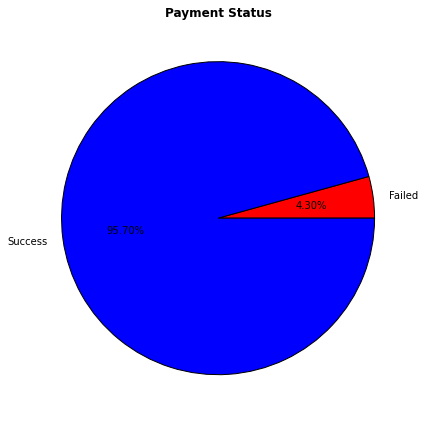

In [ ]:
payment_status = transactions.groupby('payment_status')['created_at'].count().reset_index()
payment_status = payment_status.rename(columns = {'created_at' : 'total_order'})

plt.figure(figsize = (6, 6))
plt.pie(data = payment_status, x = 'total_order', labels = 'payment_status', autopct = '%1.2f%%', wedgeprops = {'edgecolor' : 'black'}, colors = ['red', 'blue'])
plt.title('Payment Status', fontweight = 'bold', fontdict = {'fontsize' : 12})
plt.rcParams['font.size'] = 10
plt.tight_layout()

Jumlah transaksi yang gagal sangat sedikit dibandingkan transaksi yang berhasil.

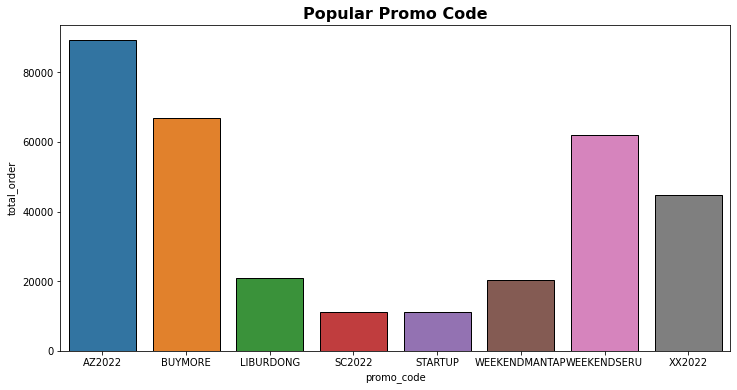

In [ ]:
promo_code = transactions_no_duplicate.groupby('promo_code')['created_at'].count().reset_index()
promo_code = promo_code.rename(columns = {'created_at' : 'total_order'})

plt.figure(figsize = (12, 6))
sns.barplot(data = promo_code, x = 'promo_code', y = 'total_order', edgecolor = 'black')
plt.title('Popular Promo Code', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

AZ2022, BUYMORE, dan WEEKENDSERU adalah kode promo yang paling banyak digunakan pelanggan.

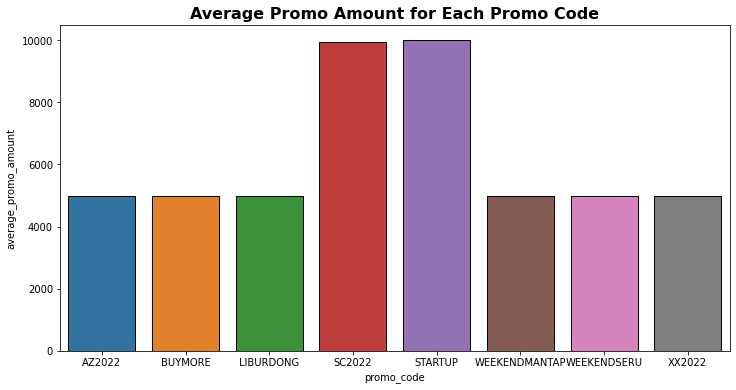

In [ ]:
promo_code = transactions_no_duplicate.groupby('promo_code')['promo_amount'].mean().reset_index()
promo_code = promo_code.rename(columns = {'promo_amount' : 'average_promo_amount'})

plt.figure(figsize = (12, 6))
sns.barplot(data = promo_code, x = 'promo_code', y = 'average_promo_amount', edgecolor = 'black')
plt.title('Average Promo Amount for Each Promo Code', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

SC2022 dan STARTUP memiliki nilai promo yang paling besar.

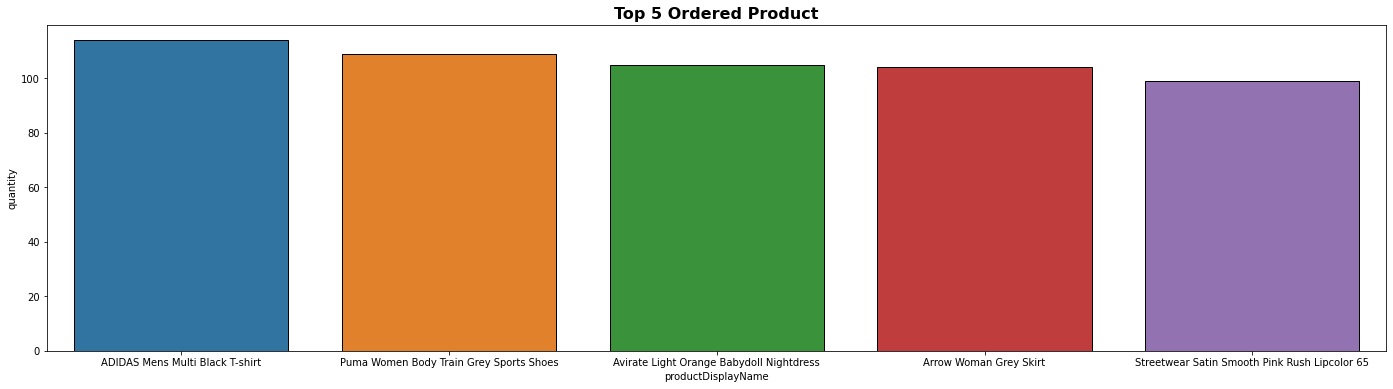

In [ ]:
product_popularity = transactions2[transactions2['payment_status'] == 'Success'].groupby('product_id')['quantity'].sum().reset_index()
top_product_popularity = product_popularity.sort_values('quantity', ascending = False)[:5]
top_product = top_product_popularity.merge(right = product[['id', 'productDisplayName']], how = 'left', left_on = 'product_id', right_on = 'id')

plt.figure(figsize = (24, 6))
sns.barplot(data = top_product, x = 'productDisplayName', y = 'quantity', edgecolor = 'black')
# sns.barplot(data = popular_product, x = 'product_id', y = 'quantity', edgecolor = 'black')
plt.title('Top 5 Ordered Product', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

Berikut adalah product yang paling banyak diorder pelanggan. Adidas Mens Multi Black T-Shirt adalah produk paling banyak dipesan.

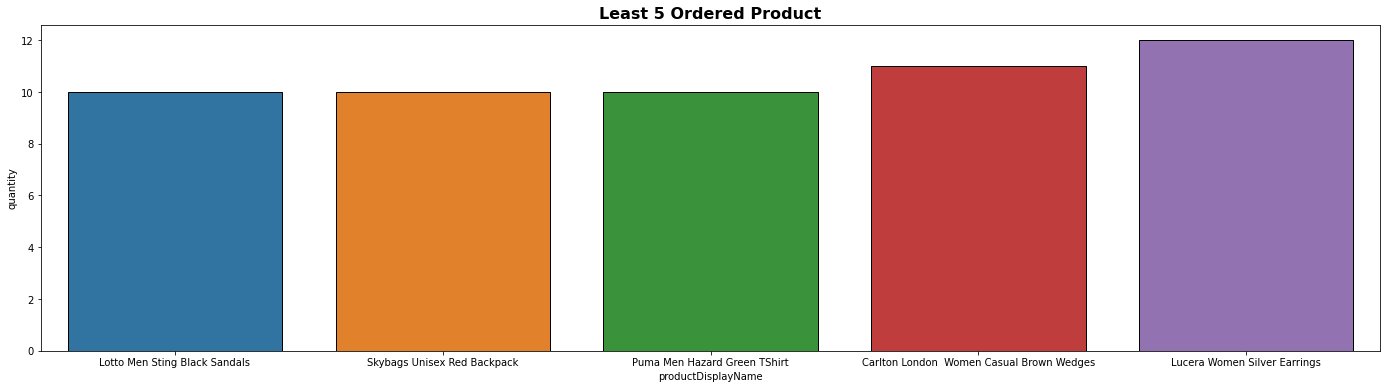

In [ ]:
least_product_popularity = product_popularity.sort_values('quantity', ascending = True)[:5]
least_product = least_product_popularity.merge(right = product[['id', 'productDisplayName']], how = 'left', left_on = 'product_id', right_on = 'id')

plt.figure(figsize = (24, 6))
sns.barplot(data = least_product, x = 'productDisplayName', y = 'quantity', edgecolor = 'black')
plt.title('Least 5 Ordered Product', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

Lotto Men Sting Black Sandals adalah produk yang jarang dipesan pelanggan.

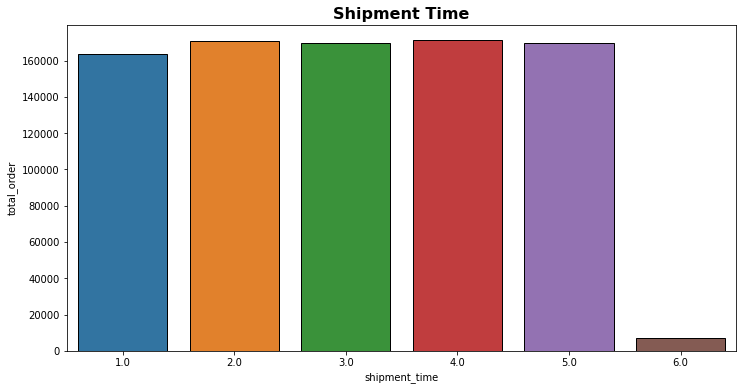

In [ ]:
shipment_time = transactions_no_duplicate.groupby('shipment_time')['created_at'].count().reset_index()
shipment_time = shipment_time.rename(columns = {'created_at' : 'total_order'})

plt.figure(figsize = (12, 6))
sns.barplot(data = shipment_time, x = 'shipment_time', y = 'total_order', edgecolor = 'black')
plt.title('Shipment Time', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

Rata-rata pengiriman harinya berkisar dari 1 - 6 hari. Jumlah pelanggan yang memiliki pengiriman harinya 6 sangat sedikit sekali jika dibandingkan dengan yang lain. Kemungkinannya adalah pelanggan hanya bisa menoleransi pengiriman hari selama 1 - 5 hari saja.

In [ ]:
transactions['created_at'] = transactions['created_at'].astype('datetime64')
transactions['created_year'] = transactions['created_at'].dt.year
transactions['created_month'] = transactions['created_at'].dt.month

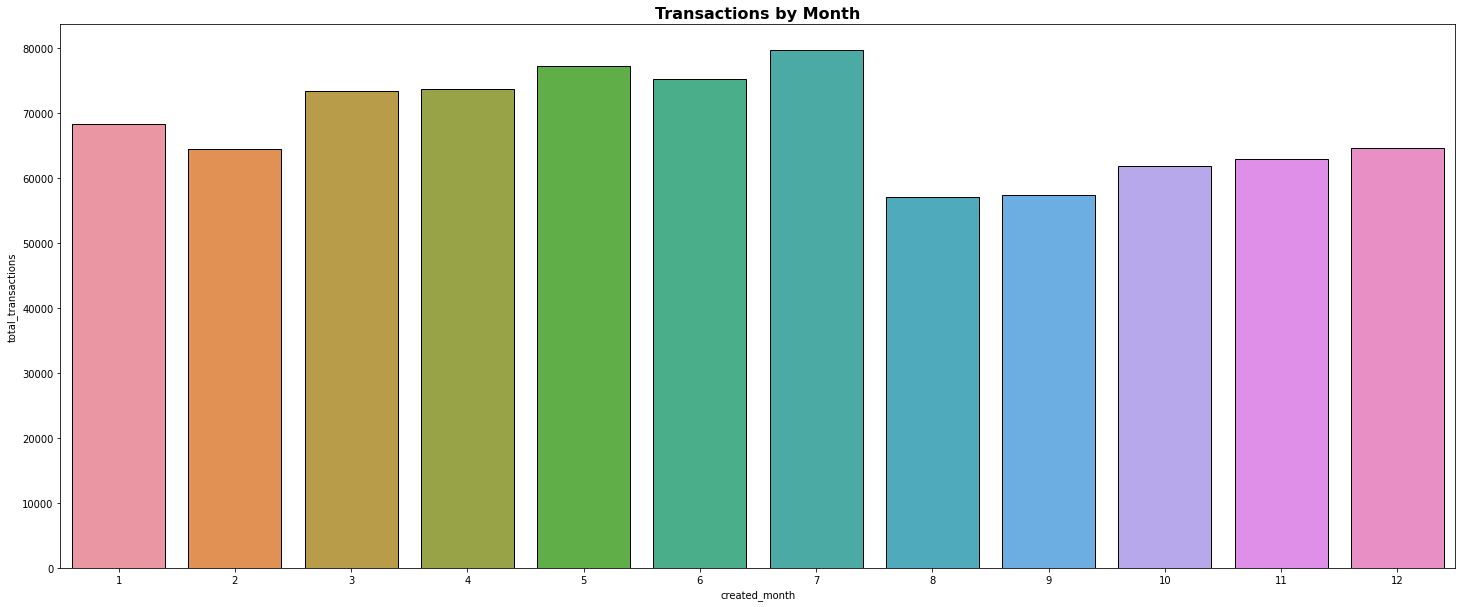

In [ ]:
transactions_success = transactions[transactions['payment_status'] == 'Success']
transactions_month = transactions_success.groupby('created_month')['created_at'].count().reset_index().rename(columns = {'created_at' : 'total_transactions'})

plt.figure(figsize = (25, 10))
sns.barplot(data = transactions_month, x = 'created_month', y = 'total_transactions', edgecolor = 'black')
plt.title('Transactions by Month', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

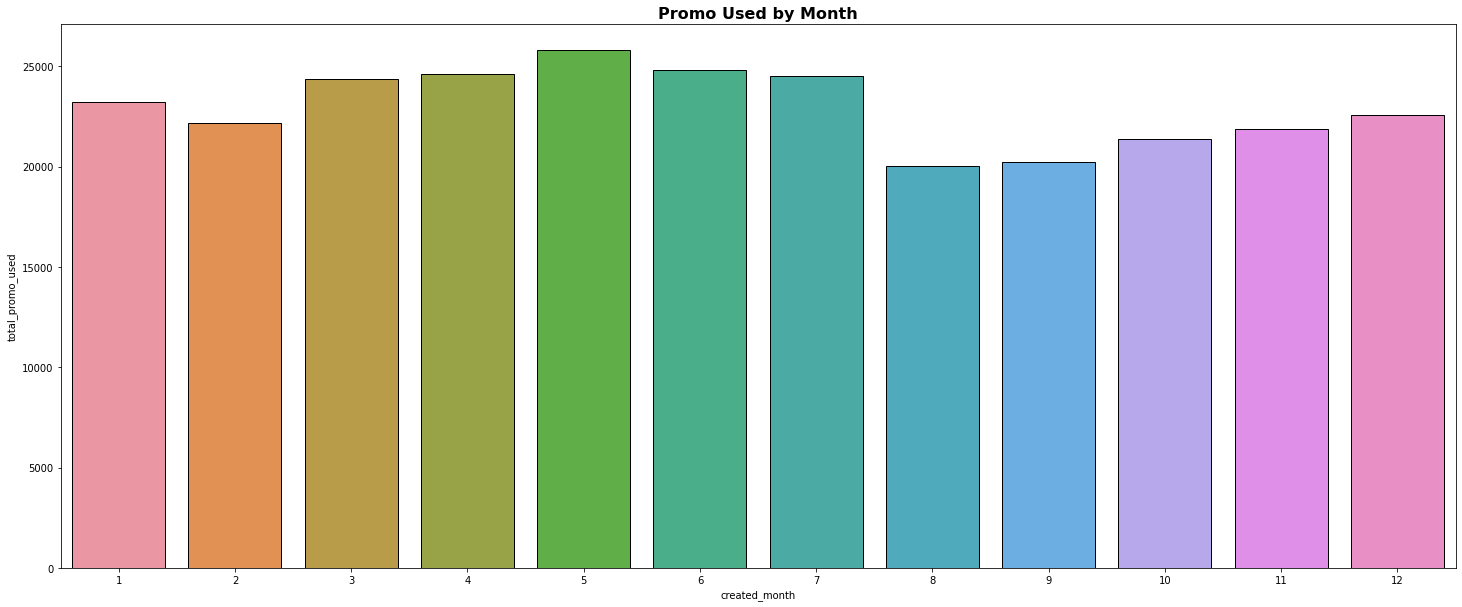

In [ ]:
transactions_promo = transactions[transactions['promo_code'].isnull() == False]
transactions_promo = transactions_promo.drop_duplicates(['customer_id', 'created_month', 'promo_year'])

promo_month = transactions_promo.groupby('created_month')['created_at'].count().reset_index().rename(columns = {'created_at' : 'total_promo_used'})

plt.figure(figsize = (25, 10))
sns.barplot(data = promo_month, x = 'created_month', y = 'total_promo_used', edgecolor = 'black')
plt.title('Promo Used by Month', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

Pemberian promo pada bulan 5 dan 12 cukup kencang. Dengan catatan bulan 1 - 7 sudah mencapai tahun 2022, sedangkan bulan 8 - 12 hanya mencapai tahun 2021.

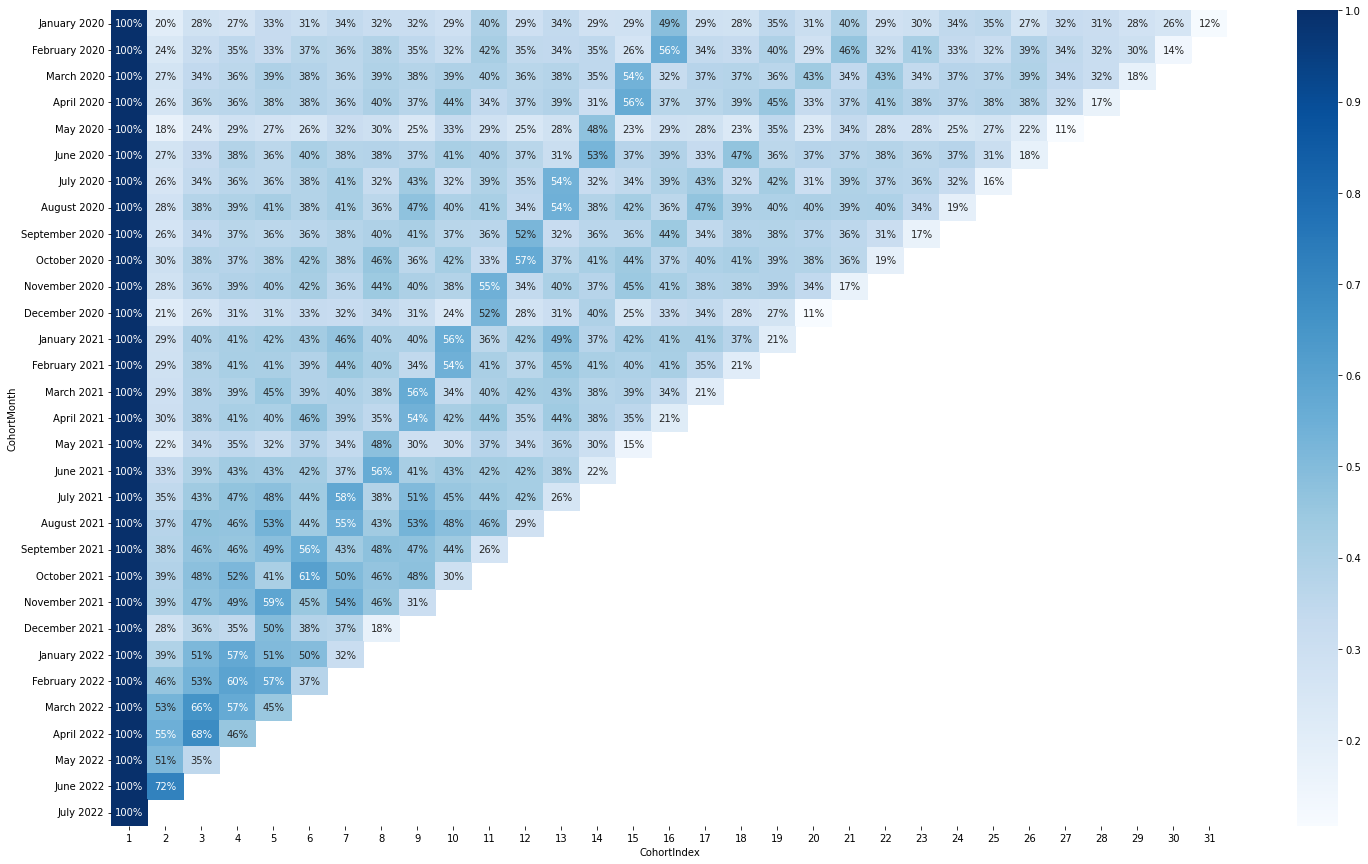

In [ ]:
cohort = transactions2[transactions2['payment_status'] == 'Success'].copy().dropna(subset = ['customer_id'])
cohort['InvoiceMonth'] = cohort['created_at'].apply(lambda x : dt.datetime(x.year, x.month, 1))

#Create a column index with the minimum invoice date aka first time customer was acquired
cohort['CohortMonth'] =  cohort.groupby('customer_id')['InvoiceMonth'].transform('min')

# create a date element function to get a series for subtraction
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

# get date elements for our cohort and invoice columns
_,Invoice_month,Invoice_year =  get_date_elements(cohort, 'InvoiceMonth')
_,Cohort_month,Cohort_year =  get_date_elements(cohort, 'CohortMonth')

#Create a cohort index
year_diff = Invoice_year - Cohort_year
month_diff = Invoice_month - Cohort_month
cohort['CohortIndex'] = year_diff * 12 + month_diff + 1

#Count the customer ID by grouping by Cohort Month  and Cohort Index
cohort_data = cohort.groupby(['CohortMonth','CohortIndex'])['customer_id'].apply(pd.Series.nunique).reset_index()

#Create a pivot table
cohort_table = cohort_data[cohort_data['CohortMonth'] >= '2020-01-01'].pivot(index = 'CohortMonth', columns = ['CohortIndex'], values='customer_id')
cohort_table = cohort_table.divide(cohort_table.iloc[:,0],axis=0)

#Change index
cohort_table.index = cohort_table.index.strftime('%B %Y')

plt.figure(figsize = (25, 15))
sns.heatmap(cohort_table, annot = True, fmt = '.0%', cmap = 'Blues')

Transaksi di bulan 7 2022 menurun.

In [ ]:
transactions_success = transactions[transactions['payment_status'] == 'Success']

def plotBarChart(title, index, values, offset=0, figsize=(17,8)):
  fig, ax = plt.subplots(figsize=figsize)

  plt.bar(index, values)

  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_x()+offset, i.get_height()*1.01,
              str(round((i.get_height()), 2)),
              color ='black')

  plt.title(title)

  # Add x, y gridlines
  ax.grid(b = True, color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)

  plt.show()

transactions_success['purchase_day'] = pd.to_datetime(transactions_success['created_at']).dt.day_name()
transactions_success['purchase_hour'] = pd.to_datetime(transactions_success['created_at']).dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


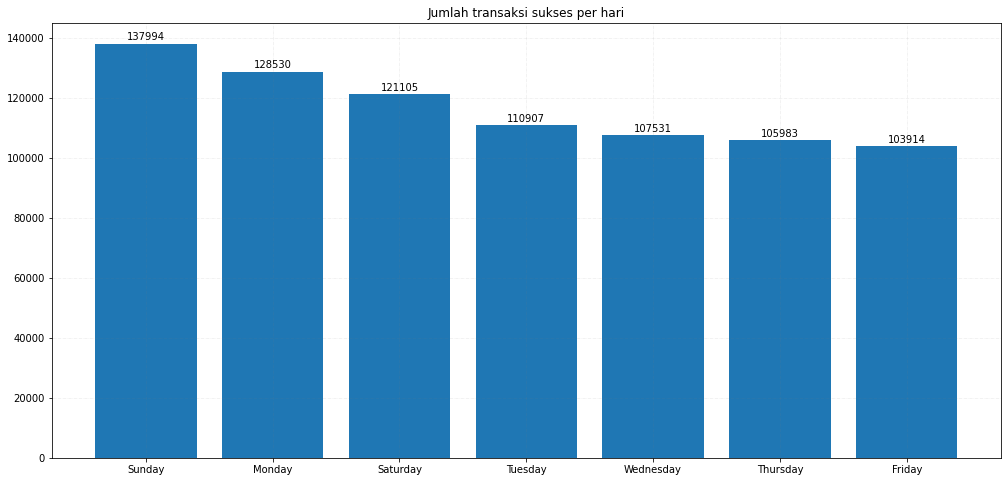

In [ ]:
plotBarChart('Jumlah transaksi sukses per hari', transactions_success['purchase_day'].value_counts().index, transactions_success['purchase_day'].value_counts().values, .25)

Pelanggan banyak melakukan order pada hari libur.

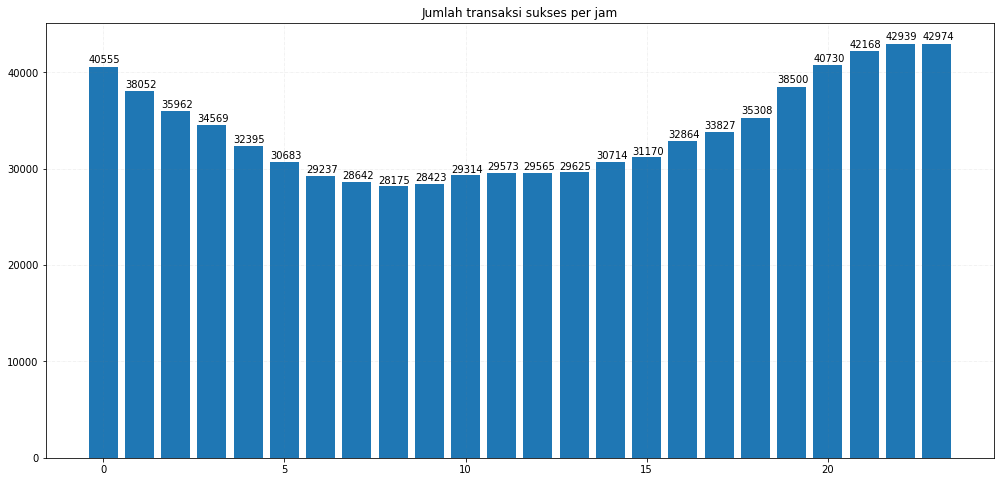

In [ ]:
plotBarChart('Jumlah transaksi sukses per jam', transactions_success['purchase_hour'].value_counts().index, transactions_success['purchase_hour'].value_counts().values)

Pelanggan banyak melakukan order dimalam hari hingga subuh. Ketika pagi dan siang hari, mereka sedang bekerja sehingga jarang melakukan order.

# Addition to UIX

In [ ]:
df_thrift = click_stream[click_stream['event_metadata'].str.contains("Thrift", na = False)]
df_thrift
# merge with transaction and customer
df_thrift_transactions = pd.merge(df_thrift, transactions2, on='session_id', how='inner')
df_exploded = pd.merge(df_thrift_transactions, customer, on='customer_id', how='inner')
df_exploded.head(3)

,session_id,event_name,event_time,event_id,traffic_source,event_metadata,event_year,created_at,customer_id,booking_id,...,home_location_lat,home_location_long,home_location,home_country,first_join_date,home_region,age,age_range,account_length,first_join_year
0,85018cbd-7801-4d0b-851a-6483366273ff,SEARCH,2019-12-06T04:25:14.425431Z,563d4ab5-f013-4df1-988b-17ab57067e56,WEB,{'search_keywords': 'Thrift'},2019,2019-12-06 13:56:00.425431,18770,3eb6ed61-beba-4c87-9b2f-81e772377f43,...,3.869205,108.126753,Kepulauan Riau,Indonesia,2019-08-31,Sulawesi,15,15 - 35,180,2019
1,4a0d7ef3-748b-4148-864c-8b6b1e890d6f,SEARCH,2021-10-16T21:54:36.425431Z,5895cfc8-13fa-48a0-a28e-cd1405a9171b,MOBILE,{'search_keywords': 'Thrift'},2021,2021-10-17 07:54:25.425431,18770,bc9b26a0-560f-474c-9d41-638937dc873f,...,3.869205,108.126753,Kepulauan Riau,Indonesia,2019-08-31,Sulawesi,15,15 - 35,180,2019
2,4604519f-c6bb-4938-a14a-cf7b20f6c339,SEARCH,2017-03-02T05:16:44.011776Z,f89918c3-4b50-4ca9-adf6-471de612dd86,MOBILE,{'search_keywords': 'Thrift'},2017,2017-03-02 10:02:59.011776,82237,d9c7663e-aad1-4db7-a5ba-2ce5d94e0be8,...,-8.164310,112.353054,Jawa Timur,Indonesia,2017-01-28,Jawa,26,15 - 35,308,2017


In [ ]:
# convert 'id' product ke integer
product['id'] = product['id'].astype(int)

# merge with product
df_exploded = pd.merge(df_exploded, product, left_on='product_id', right_on='id', how='inner')
df_exploded.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata,event_year,created_at,customer_id,booking_id,...,id,productGender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,85018cbd-7801-4d0b-851a-6483366273ff,SEARCH,2019-12-06T04:25:14.425431Z,563d4ab5-f013-4df1-988b-17ab57067e56,WEB,{'search_keywords': 'Thrift'},2019,2019-12-06 13:56:00.425431,18770,3eb6ed61-beba-4c87-9b2f-81e772377f43,...,32439,Men,Apparel,Topwear,Tshirts,Black,Summer,2012,Sports,ADIDAS Men Black T-shirt
1,5dce209f-144f-4a76-95f5-249f5bd56c55,SEARCH,2021-10-07T21:15:56.487416Z,e988754c-11ae-4259-b88d-a899746e132a,MOBILE,{'search_keywords': 'Thrift'},2021,2021-09-28 06:11:41.487416,67418,765040fa-4857-4f04-8f5f-2943b8e70aad,...,32439,Men,Apparel,Topwear,Tshirts,Black,Summer,2012,Sports,ADIDAS Men Black T-shirt
2,4a0d7ef3-748b-4148-864c-8b6b1e890d6f,SEARCH,2021-10-16T21:54:36.425431Z,5895cfc8-13fa-48a0-a28e-cd1405a9171b,MOBILE,{'search_keywords': 'Thrift'},2021,2021-10-17 07:54:25.425431,18770,bc9b26a0-560f-474c-9d41-638937dc873f,...,8313,Women,Accessories,Bags,Handbags,Black,Winter,2016,Casual,Fastrack Women Nylon Black Handbag
3,41590ba1-0d97-4737-bfdc-e38e344e226d,SEARCH,2022-02-18T00:11:10.351911Z,22eadd4f-7383-4619-8de5-7cd1bc0858b8,MOBILE,{'search_keywords': 'Thrift'},2022,2022-02-18 01:02:32.351911,49539,8bb05d72-927b-427e-ab75-aa78f237cba7,...,8313,Women,Accessories,Bags,Handbags,Black,Winter,2016,Casual,Fastrack Women Nylon Black Handbag
4,b5305856-3b7f-48ea-8e43-60753ac8cf47,SEARCH,2021-03-06T12:00:28.955637Z,41d7974c-faa6-46c3-8ec0-10060cc67b89,MOBILE,{'search_keywords': 'Thrift'},2021,2021-03-06 18:47:58.955637,48194,04ca95d6-c0cd-4849-ac3e-c04302574b3b,...,8313,Women,Accessories,Bags,Handbags,Black,Winter,2016,Casual,Fastrack Women Nylon Black Handbag


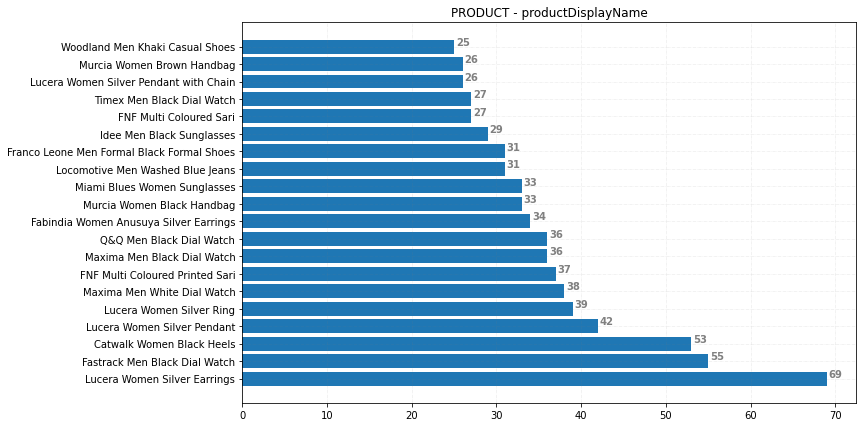

In [ ]:
# THRIFT
# ALL GENDER (MEN, WOMEN, BOYS, GIRLS)
fig, ax = plt.subplots( figsize=(11,7))

plt.barh(     df_exploded['productDisplayName'].value_counts().head(20).index,
              df_exploded['productDisplayName'].value_counts().head(20).values)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.title('PRODUCT - productDisplayName')

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.show()


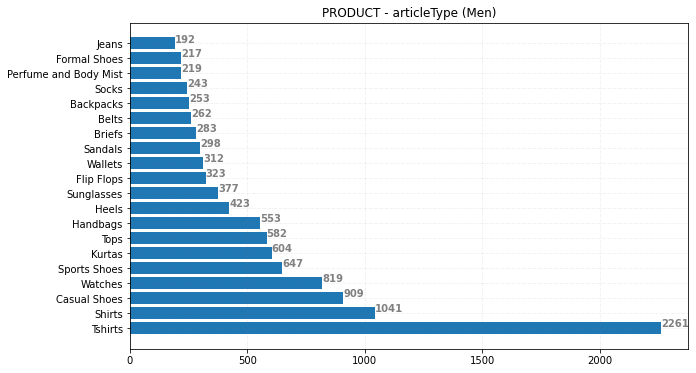

In [ ]:
# THRIFT
# MAN (M dan >=15)
fig, ax = plt.subplots(figsize=(10,6))

plt.barh(       df_exploded[(df_exploded['gender'] == 'M') & (df_exploded['age'] >= 15)]['articleType'].value_counts().head(20).index,
                df_exploded[(df_exploded['gender'] == 'M') & (df_exploded['age'] >= 15)]['articleType'].value_counts().head(20).values)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.title('PRODUCT - articleType (Men)')

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.show()

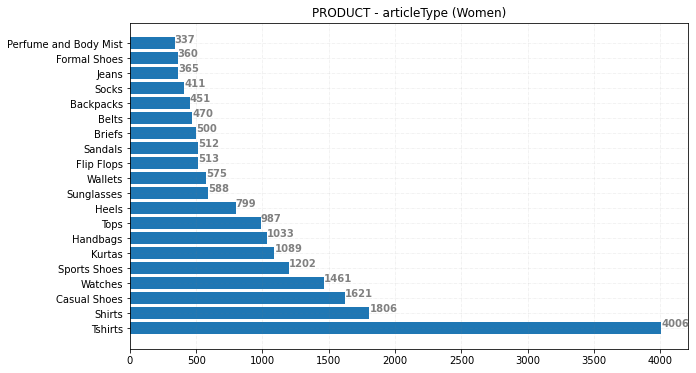

In [ ]:
# THRIFT
# WOMEN (F dan >=15)

fig, ax = plt.subplots(figsize=(10,6))

plt.barh(   df_exploded[(df_exploded['gender'] == 'F') & (df_exploded['age'] >= 15)]['articleType'].value_counts().head(20).index,
            df_exploded[(df_exploded['gender'] == 'F') & (df_exploded['age'] >= 15)]['articleType'].value_counts().head(20).values)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.title('PRODUCT - articleType (Women)')

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.show()


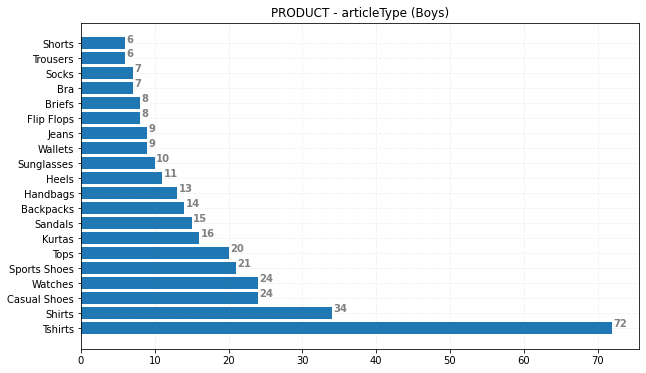

In [ ]:
# THRIFT
# BOYS (M dan <15)

fig, ax = plt.subplots(figsize=(10,6))

plt.barh(   df_exploded[(df_exploded['gender'] == 'M') & (df_exploded['age'] < 15)]['articleType'].value_counts().head(20).index,
            df_exploded[(df_exploded['gender'] == 'M') & (df_exploded['age'] < 15)]['articleType'].value_counts().head(20).values)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.title('PRODUCT - articleType (Boys)')

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.show()


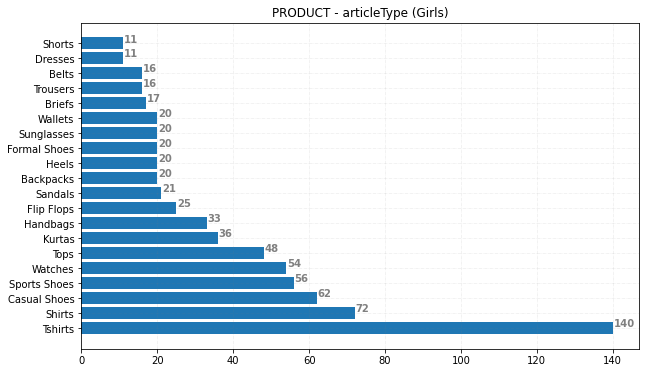

In [ ]:
# THRIFT
# GIRLS (M dan <15)

fig, ax = plt.subplots(figsize=(10,6))

plt.barh(   df_exploded[(df_exploded['gender'] == 'F') & (df_exploded['age'] < 15)]['articleType'].value_counts().head(20).index,
            df_exploded[(df_exploded['gender'] == 'F') & (df_exploded['age'] < 15)]['articleType'].value_counts().head(20).values)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
plt.title('PRODUCT - articleType (Girls)')

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.show()


# **Feature Engineering** <small> (for modelling) </small>

In [ ]:
#Merge
df = pd.merge(left = customer, right = transactions2, on = 'customer_id', how = 'left')
product = product.rename(columns = {'gender' : 'productGender'})
df = pd.merge(left = df, right = product, left_on = 'product_id', right_on = 'id', how='left')

Features:                    
1. home_region: lokasi region rumah                      
2. gender: jenis kelamin                          
3. device_type: tipe perangkat                     
4. age: umur                             
5. account_length: lama akun (dalam bulan)                 
6. tot_session: total sesi                 
7. tot_time_spent: total waktu yang dihabiskan (dalam detik)              
8. fav_payment_method: tipe pembayaran yang sering digunakan          
9. tot_order: total order                   
10. tot_click: total click                   
11. tot_homepage: total melihat homepage                
12. tot_add_to_cart: total menambah barang ke keranjang             
13. tot_scroll: total scroll                  
14. tot_item_detail: total melihat item detail             
15. tot_search: total pencarian                  
16. tot_booking: total booking                 
17. tot_promo_page: total melihat promo page              
18. tot_add_promo: total menambah promo               
19. tot_amount: total uang yang dihabiskan                  
20. avg_amount: rata-rata uang yang dihabiskan                 
21. std_amount: standar deviasi uang yang dihabiskan                  
22. tot_quantity: total barang yang dipesan                
23. avg_quantity: rata-rata barang yang dipesan                
24. std_quantity: standar deviasi barang yang dipesan                
25. tot_promo_amount: total nilai promo yang digunakan            
26. avg_promo_amount: rata-rata nilai promo yang digunakan            
27. std_promo_amount: standar deviasi nilai promo yang digunakan            
28. tot_shipment_fee: total biaya pengiriman            
29. avg_shipment_fee: rata-rata biaya pengiriman            
30. std_shipment_fee: standar deviasi biaya pengiriman            
31. avg_shipment_time: rata-rata waktu pengiriman           
32. num_promo_code_used: jumlah kode promo yang digunakan         
33. num_0_shipment_fee: jumlah dimana biaya pengiriman 0          
34. recency: total hari sejak pelanggan terakhir transaksi                     
35. fav_traffic_source: traffic source yang sering digunakan          
36. num_order_distinct_product: jumlah pembelian produk berbeda  

## **Features + Churn Function**

In [ ]:
def getFeaturesOnePeriod(start_date, end_date, index):
        m1_Q1 = df[((df['created_at'] >= start_date) & (df['created_at'] < end_date)) |
                ((df['created_at'].isnull() == True)  & ((df['first_join_date'] >= start_date) & (df['first_join_date'] < end_date)))]

        m1_Q1_click_stream = click_stream[(click_stream['event_time'] >= start_date) & (click_stream['event_time'] < end_date)]

        m1_Q1_created_distinct = m1_Q1.drop_duplicates(['customer_id', 'created_at'])

        m1_Q1_success_recency = m1_Q1_created_distinct[m1_Q1_created_distinct['payment_status'] == 'Success']

        m1_Q1_amount_qty_promo_fee_time_code_0 = m1_Q1[m1_Q1['payment_status'] == 'Success'].drop_duplicates(['booking_id'])

        m1_Q1_product_distinct = m1_Q1[m1_Q1['payment_status'] == 'Success'].drop_duplicates(['customer_id', 'baseColour', 'year', 'productDisplayName'])

        #tot_time_spent
        m1_Q1_session_min_max = m1_Q1_click_stream.groupby(['session_id']).agg({'event_time' : ['min', 'max']}).droplevel(0, axis = 1).reset_index()
        m1_Q1_session_min_max['delta'] = m1_Q1_session_min_max['max'].astype('datetime64') - m1_Q1_session_min_max['min'].astype('datetime64')
        m1_Q1_session_min_max['delta'] = pd.to_timedelta(m1_Q1_session_min_max['delta']).apply(lambda x: x.total_seconds())

        m1_Q1_session_distinct = m1_Q1.drop_duplicates(['customer_id', 'session_id'])[['customer_id', 'session_id']]

        m1_Q1_session_time = m1_Q1_session_min_max.merge(right = m1_Q1_session_distinct, how = 'right', on = 'session_id')

        m1_Q1_time_spent = m1_Q1_session_time.groupby(['customer_id']).agg({'session_id' : 'count', 'delta' : 'sum'}).reset_index().rename(
            columns = {'session_id' : 'tot_session_Q'+str(index), 'delta' : 'tot_time_spent_Q'+str(index)})


        #fav_payment_method
        m1_Q1_payment_method = m1_Q1_created_distinct.groupby(['customer_id'])['payment_method'].value_counts()
        m1_Q1_payment_method = m1_Q1_payment_method.reset_index(name = 'count').rename(columns = {'payment_method' : 'fav_payment_method_Q'+str(index)})
        m1_Q1_payment_method.drop_duplicates('customer_id', inplace = True)
        m1_Q1_payment_method.drop('count', axis = 1, inplace = True)

        #tot_order
        m1_Q1_total_order = m1_Q1_success_recency.groupby(['customer_id'])['payment_status'].count().reset_index().rename(
            columns = {'payment_status' : 'tot_order_Q'+str(index)})


        #Total Click
        m1_Q1_click = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'CLICK'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_click_Q'+str(index)})
        #Total Homepage
        m1_Q1_homepage = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'HOMEPAGE'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_homepage_Q'+str(index)})
        #Total Add To Cart
        m1_Q1_add_to_cart = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'ADD_TO_CART'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_add_to_cart_Q'+str(index)})
        #Total Scroll
        m1_Q1_scroll = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'SCROLL'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_scroll_Q'+str(index)})
        #Total Item Detail
        m1_Q1_item_detail = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'ITEM_DETAIL'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_item_detail_Q'+str(index)})
        #Total Search
        m1_Q1_search = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'SEARCH'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_search_Q'+str(index)})
        #Total Booking
        m1_Q1_booking = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'BOOKING'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_booking_Q'+str(index)})
        #Total Promo Page
        m1_Q1_promo_page = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'PROMO_PAGE'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_promo_page_Q'+str(index)})
        #Total Add Promo
        m1_Q1_add_promo = m1_Q1_click_stream[m1_Q1_click_stream['event_name'] == 'ADD_PROMO'].groupby(['session_id'])['event_name'].count().reset_index().rename(
            columns = {'event_name' : 'tot_add_promo_Q'+str(index)})
        #Merge All Total
        m1_Q1_all = pd.merge(left = m1_Q1_click, right = m1_Q1_homepage, how = 'outer', on = 'session_id')
        m1_Q1_all = m1_Q1_all.merge(right = m1_Q1_add_to_cart, how = 'outer', on = 'session_id')
        m1_Q1_all = m1_Q1_all.merge(right = m1_Q1_scroll, how = 'outer', on = 'session_id')
        m1_Q1_all = m1_Q1_all.merge(right = m1_Q1_item_detail, how = 'outer', on = 'session_id')
        m1_Q1_all = m1_Q1_all.merge(right = m1_Q1_search, how = 'outer', on = 'session_id')
        m1_Q1_all = m1_Q1_all.merge(right = m1_Q1_booking, how = 'outer', on = 'session_id')
        m1_Q1_all = m1_Q1_all.merge(right = m1_Q1_promo_page, how = 'outer', on = 'session_id')
        m1_Q1_all = m1_Q1_all.merge(right = m1_Q1_add_promo, how = 'outer', on = 'session_id')
        #Merge w/ Customer
        m1_Q1_event = pd.merge(left = m1_Q1_created_distinct, right = m1_Q1_all, how = 'left', on = 'session_id')
        m1_Q1_event = m1_Q1_event.groupby(['customer_id']).agg({'tot_click_Q'+str(index) : 'sum', 'tot_homepage_Q'+str(index) : 'sum', 'tot_add_to_cart_Q'+str(index) : 'sum', 'tot_scroll_Q'+str(index) : 'sum',
                                                        'tot_item_detail_Q'+str(index) : 'sum', 'tot_search_Q'+str(index) : 'sum', 'tot_booking_Q'+str(index) : 'sum',
                                                        'tot_promo_page_Q'+str(index) : 'sum', 'tot_add_promo_Q'+str(index) : 'sum'}).reset_index()


        #Amount
        m1_Q1_amount = m1_Q1_amount_qty_promo_fee_time_code_0.groupby(['customer_id']).agg({'total_amount' : ['sum', 'mean', 'std']}).droplevel(
            0, axis = 1).reset_index().rename(columns = {'sum' : 'tot_amount_Q'+str(index), 'mean' : 'avg_amount_Q'+str(index), 'std' : 'std_amount_Q'+str(index)})
        #Quantity
        m1_Q1_qty = m1_Q1_amount_qty_promo_fee_time_code_0.groupby(['customer_id']).agg({'quantity' : ['sum', 'mean', 'std']}).droplevel(
            0, axis = 1).reset_index().rename(columns = {'sum' : 'tot_quantity_Q'+str(index), 'mean' : 'avg_quantity_Q'+str(index), 'std' : 'std_quantity_Q'+str(index)})
        #Promo Amount
        m1_Q1_promo = m1_Q1_amount_qty_promo_fee_time_code_0.groupby(['customer_id']).agg({'promo_amount' : ['sum', 'mean', 'std']}).droplevel(
            0, axis = 1).reset_index().rename(columns = {'sum' : 'tot_promo_amount_Q'+str(index), 'mean' : 'avg_promo_amount_Q'+str(index), 'std' : 'std_promo_amount_Q'+str(index)})
        #Shipment Fee
        m1_Q1_shipment_fee = m1_Q1_amount_qty_promo_fee_time_code_0.groupby(['customer_id']).agg({'shipment_fee' : ['sum', 'mean', 'std']}).droplevel(
            0, axis = 1).reset_index().rename(columns = {'sum' : 'tot_shipment_fee_Q'+str(index), 'mean' : 'avg_shipment_fee_Q'+str(index), 'std' : 'std_shipment_fee_Q'+str(index)})
        #Shipment Time
        m1_Q1_shipment_time = m1_Q1_amount_qty_promo_fee_time_code_0.groupby(['customer_id'])['shipment_time'].mean().reset_index().rename(
            columns = {'shipment_time' : 'avg_shipment_time_Q'+str(index)})
        #Number of Promo Code Used
        m1_Q1_number_promo_code_used = m1_Q1_amount_qty_promo_fee_time_code_0.groupby(['customer_id'])['promo_code'].count().reset_index().rename(
            columns = {'promo_code' : 'num_promo_code_used_Q'+str(index)})
        #Number of 0 Shipment Fee
        m1_Q1_0 = m1_Q1_amount_qty_promo_fee_time_code_0[m1_Q1_amount_qty_promo_fee_time_code_0['shipment_fee'] == 0]
        m1_Q1_number_0_shipment_fee = m1_Q1_0.groupby(['customer_id'])['promo_code'].count().reset_index().rename(columns = {'promo_code' : 'num_0_shipment_fee_Q'+str(index)})

        #Recency
        m1_Q1_recency = m1_Q1_success_recency.groupby(['customer_id'])['created_at'].max().reset_index()
        m1_Q1_recency = m1_Q1_recency.rename(columns = {'created_at' : 'last_order_date'})
        m1_Q1_recency['recency_Q'+str(index)] = (m1_Q1_recency['last_order_date'].max() - m1_Q1_recency['last_order_date'].astype('datetime64')).astype('timedelta64[D]')
        m1_Q1_recency = m1_Q1_recency.drop('last_order_date', axis = 1)

        #fav_traffic_source
        m1_Q1_click_stream_traffic = m1_Q1_click_stream.drop_duplicates(['session_id'])
        m1_Q1_session_id = m1_Q1.drop_duplicates(['session_id'])

        m1_Q1_session_traffic = m1_Q1_session_id.merge(right = m1_Q1_click_stream_traffic, how = 'left', on = 'session_id')

        m1_Q1_traffic_source = m1_Q1_session_traffic.groupby(['customer_id'])['traffic_source'].value_counts()
        m1_Q1_traffic_source = m1_Q1_traffic_source.reset_index(name = 'count').rename(columns = {'traffic_source' : 'fav_traffic_source_Q'+str(index)})
        m1_Q1_traffic_source.drop_duplicates('customer_id', inplace = True)
        m1_Q1_traffic_source.drop('count', axis = 1, inplace = True)

        #num_order_distinct_product
        m1_Q1_order_distinct_product = m1_Q1_product_distinct.groupby(['customer_id'])['productDisplayName'].count().reset_index().rename(
            columns = {'productDisplayName' : 'num_order_distinct_product_Q'+str(index)})

        #Merge all features
        df_m1_Q1 = m1_Q1_time_spent.merge(right = m1_Q1_payment_method, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_total_order, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_event, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_amount, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_qty, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_promo, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_shipment_fee, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_shipment_time, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_number_promo_code_used, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_number_0_shipment_fee, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_recency, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_traffic_source, how = 'left', on = 'customer_id')
        df_m1_Q1 = df_m1_Q1.merge(right = m1_Q1_order_distinct_product, how = 'left', on = 'customer_id')

        return df_m1_Q1

In [ ]:
def getFeaturesChurn(start_date, end_date, divider):
        # divider merupakan parameter untuk menentukan jumlah pembagian data
        # misal divider = 3, maka data akan dibagi menjadi 3 bagian dari start date sampai end date

        # penentu churn ada di bulan dalam parameter 'end_date'
        print(start_date + " - " + end_date)

        # convert to datetime64
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        diff_month = round((end_date - start_date).days / 30)
        print("Rentang bulan : " + str(diff_month)) # buat ngedebug jumlah perbedaan bulannya apakah bener (kalo mau hapus baris ini gpp, gapengaruh ke logic codenya)

        # convert ke date (error di getFeaturesChurn)
        df['first_join_date'] = pd.to_datetime(df['first_join_date']).dt.date

        # convert ke date (error di getFeaturesOnePeriod)
        click_stream['event_time'] = pd.to_datetime(click_stream['event_time']).dt.date

        m_customer = df[df['first_join_date'] < end_date].drop_duplicates('customer_id')[['customer_id', 'home_region', 'gender', 'device_type', 'birthdate', 'first_join_date']]
        m_customer['age'] = (pd.to_datetime(end_date - pd.DateOffset(days=1), format = '%Y-%m-%d') - pd.to_datetime(m_customer['birthdate'])).astype('timedelta64[Y]').astype('int')
        m_customer['account_length'] = (pd.to_datetime(end_date - pd.DateOffset(days=1), format = '%Y-%m-%d') - pd.to_datetime(m_customer['first_join_date'])).astype('timedelta64[M]').astype('int')
        m_customer = m_customer.drop(['birthdate', 'first_join_date'], axis = 1)

        df_mAB = m_customer.copy()

        # loop sebanyak 'divider', panggil function getFeaturesOnePeriod untuk mendapatkan data di pembagian bulan tersebut
        for i in range(divider):
                print(" => Q"+str(i+1) + " : " + str(start_date + pd.DateOffset(months=round(diff_month/divider)*i)) + " - " + str(start_date+ pd.DateOffset(months=round(diff_month/divider)*(i+1))))
                df_mAB = df_mAB.merge(right = getFeaturesOnePeriod((start_date + pd.DateOffset(months=round(diff_month/divider)*i)), (start_date+ pd.DateOffset(months=round(diff_month/divider)*(i+1))), i+1), how='outer', on='customer_id')


        #Bulan
        m = df[((df['created_at'] >= end_date) & (df['created_at'] < (end_date + pd.DateOffset(months=1)).replace(day=1))) |
                ((df['created_at'].isnull() == True)  & ((df['first_join_date'] >= end_date) & (df['first_join_date'] < (end_date + pd.DateOffset(months=1)).replace(day=1))))]

        #Total Order
        m_created_distinct = m.drop_duplicates(['customer_id', 'created_at'])
        m_success = m_created_distinct[m_created_distinct['payment_status'] == 'Success']

        m_payment_success = m_success.groupby(['customer_id'])['payment_status'].count().reset_index()
        m_payment_success = m_payment_success.rename(columns = {'payment_status' : 'tot_order_m'})
        m_customer_distinct = m.drop_duplicates('customer_id')
        df_m = m_customer_distinct[['customer_id']].merge(right = m_payment_success, how = 'outer', on = 'customer_id')
        df_m['tot_order_m'] = df_m['tot_order_m'].fillna(0)


        df_ABC = df_mAB.merge(right = df_m, how = 'outer', on = 'customer_id')
        for i in range(divider):
                df_ABC = df_ABC[df_ABC['tot_order_Q'+str(i+1)].isnull() == False]

        df_ABC['churn'] = df_ABC['tot_order_m'].apply(lambda x: 0 if x > 0 else 1)
        df_ABC = df_ABC.drop(['tot_order_m'], axis = 1)
        #df_ABC = df_ABC.fillna(0)

        return df_ABC.copy()

## **Train & Test Data**

In [ ]:
#TRAIN

#Features (Bulan 6 2022) + Churn (Bulan 7 2022)
train_1 = getFeaturesChurn('2022-06-01', '2022-07-01', 1) #Customer Turun
#Features (Bulan 5 2022) + Churn (Bulan 6 2022)
train_2 = getFeaturesChurn('2022-05-01', '2022-06-01', 1) #Customer Turun
#Features (Bulan 3 2022) + Churn (Bulan 4 2022)
train_3 = getFeaturesChurn('2022-03-01', '2022-04-01', 1) #Customer Naik
#Features (Bulan 2 2022) + Churn (Bulan 3 2022)
train_4 = getFeaturesChurn('2022-02-01', '2022-03-01', 1) #Customer Naik
#Features (Bulan 1 2022) + Churn (Bulan 2 2022)
train_5 = getFeaturesChurn('2022-04-01', '2022-05-01', 1) #Customer Turun
#Features (Bulan 12 2021) + Churn (Bulan 1 2022)
train_6 = getFeaturesChurn('2021-12-01', '2022-01-01', 1) #Customer Naik
#Features (Bulan 11 2021) + Churn (Bulan 12 2021)
train_7 = getFeaturesChurn('2021-11-01', '2021-12-01', 1) #Customer Naik

train = pd.concat([train_1, train_2, train_3, train_4, train_5, train_6, train_7])


#TEST

#Features (Bulan 1 2022) + Churn (Bulan 2 2022)
test_1 = getFeaturesChurn('2022-01-01', '2022-02-01', 1) #Customer Turun
#Features (Bulan 10 2021) + Churn (Bulan 11 2021)
test_2 = getFeaturesChurn('2021-10-01', '2021-11-01', 1) #Customer Naik

test = pd.concat([test_1, test_2])
test = test.dropna(subset = ['fav_traffic_source_Q1'])

2022-06-01 - 2022-07-01
Rentang bulan : 1


/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


 => Q1 : 2022-06-01 00:00:00 - 2022-07-01 00:00:00
2022-05-01 - 2022-06-01
Rentang bulan : 1
 => Q1 : 2022-05-01 00:00:00 - 2022-06-01 00:00:00
2022-03-01 - 2022-04-01
Rentang bulan : 1
 => Q1 : 2022-03-01 00:00:00 - 2022-04-01 00:00:00
2022-02-01 - 2022-03-01
Rentang bulan : 1
 => Q1 : 2022-02-01 00:00:00 - 2022-03-01 00:00:00
2022-04-01 - 2022-05-01
Rentang bulan : 1
 => Q1 : 2022-04-01 00:00:00 - 2022-05-01 00:00:00
2021-12-01 - 2022-01-01
Rentang bulan : 1
 => Q1 : 2021-12-01 00:00:00 - 2022-01-01 00:00:00
2021-11-01 - 2021-12-01
Rentang bulan : 1
 => Q1 : 2021-11-01 00:00:00 - 2021-12-01 00:00:00
2022-01-01 - 2022-02-01
Rentang bulan : 1
 => Q1 : 2022-01-01 00:00:00 - 2022-02-01 00:00:00
2021-10-01 - 2021-11-01
Rentang bulan : 1
 => Q1 : 2021-10-01 00:00:00 - 2021-11-01 00:00:00


In [ ]:
#Datasets for EDA
eda_train = train.copy()
eda_test = test.copy()

eda_train = eda_train.fillna(0)
eda_test = eda_test.fillna(0)

## **EDA**

0    63732
1    38502
Name: churn, dtype: int64
0    62.339339
1    37.660661
Name: churn, dtype: float64


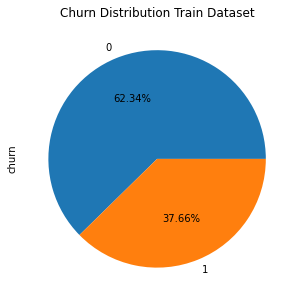

In [ ]:
print(eda_train['churn'].value_counts())
print(eda_train['churn'].value_counts().apply(lambda x : x/eda_train['churn'].shape[0]*100))

plt.title('Churn Distribution Train Dataset')
eda_train['churn'].value_counts().plot(kind = 'pie', autopct = '%.2f%%', figsize = (5, 5))

0    19664
1    13503
Name: churn, dtype: int64
0    59.287846
1    40.712154
Name: churn, dtype: float64


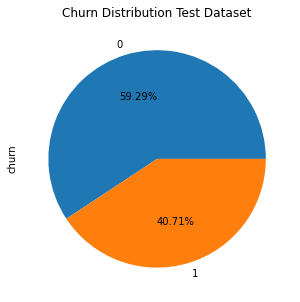

In [ ]:
print(eda_test['churn'].value_counts())
print(eda_test['churn'].value_counts().apply(lambda x : x/eda_test['churn'].shape[0]*100))


plt.title('Churn Distribution Test Dataset')
eda_test['churn'].value_counts().plot(kind = 'pie', autopct = '%.2f%%', figsize = (5, 5))

## **Feature Selection (Information Value)**

In [ ]:
def calc_iv(df, feature, target, pr = False):

    lst = []

    df[feature] = df[feature].fillna('NULL')

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE' : {np.inf : 0, -np.inf : 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by = ['Variable', 'Value'], ascending = [True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [ ]:
iv_df = train.drop(['customer_id', 'churn'], axis = 1)
iv_df['target'] = train['churn']

features = iv_df.columns[:-1].tolist()

iv_list = []
for feature in features:
    iv, data = calc_iv(iv_df, feature, 'target')
    iv_list.append(round(iv, 6))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]),
                      columns = ['Feature', 'iv'])
woe_df

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Feature,iv
0,home_region,0.000323
1,gender,0.0
2,device_type,9e-06
3,age,0.003442
4,account_length,0.088497
5,tot_session_Q1,1.662202
6,tot_time_spent_Q1,0.310607
7,fav_payment_method_Q1,0.008649
8,tot_order_Q1,1.593112
9,tot_click_Q1,0.978307


In [ ]:
train = train[['customer_id', 'account_length', 'tot_time_spent_Q1', 'tot_add_to_cart_Q1', 'tot_promo_page_Q1', 'tot_add_promo_Q1', 'tot_amount_Q1',
               'avg_amount_Q1', 'std_amount_Q1', 'avg_quantity_Q1', 'num_promo_code_used_Q1', 'num_0_shipment_fee_Q1', 'recency_Q1','fav_traffic_source_Q1',
               'churn']]
test = test[['customer_id', 'account_length', 'tot_time_spent_Q1', 'tot_add_to_cart_Q1', 'tot_promo_page_Q1', 'tot_add_promo_Q1', 'tot_amount_Q1',
             'avg_amount_Q1', 'std_amount_Q1', 'avg_quantity_Q1', 'num_promo_code_used_Q1', 'num_0_shipment_fee_Q1', 'recency_Q1', 'fav_traffic_source_Q1',
             'churn']]

## **Data Pre-processing**

In [ ]:
#Handle null values
train = train.fillna(0)
test = test.fillna(0)


#Label Encoder
fts_le = LabelEncoder()
train['fav_traffic_source_Q1'] = fts_le.fit_transform(train['fav_traffic_source_Q1'])
test['fav_traffic_source_Q1'] = fts_le.transform(test['fav_traffic_source_Q1'])

In [ ]:
#TRAIN
X_train = train.drop(['customer_id', 'churn'], axis = 1)
y_train = train['churn']


#TEST
X_test = test.drop(['customer_id', 'churn'], axis = 1)
y_test = test['churn']

# **Models**

## **Baseline Models Function**

In [ ]:
skf = StratifiedKFold(n_splits = 5)

In [ ]:
def baseline_models(classifier, X_train, X_test, y_train, y_test):
  global models_arr
  models_arr = []

  clf_name = []
  train_acc = []
  test_acc = []
  precision = []
  recall = []
  f1 = []
  roc_auc = []
  cv_mean = []
  cv_std = []

  for clf in classifier:
    model_fit = clf.fit(X_train, y_train)

    models_arr.append(model_fit)

    clf_name.append(clf.__class__.__name__)
    y_pred = clf.predict(X_test)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    cv_mean.append(cross_val_score(clf, X_train, y_train, cv = skf).mean())
    cv_std.append(cross_val_score(clf, X_train, y_train, cv = skf).std())

  #Dataframe
  models = pd.DataFrame({
    'Model': clf_name,
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'ROC AUC': roc_auc,
    'CV mean': cv_mean,
    'CV std': cv_std
    })

  models = models.sort_values(by = 'ROC AUC', ascending = False)

  return models

## **Baseline Models**

In [ ]:
classifier = [LogisticRegression(), GaussianNB(), GradientBoostingClassifier(), XGBClassifier(), LGBMClassifier()]

baseline_models = baseline_models(classifier, X_train, X_test, y_train, y_test)
baseline_models

,Model,Train Accuracy,Test Accuracy,Precision,Recall,f1,ROC AUC,CV mean,CV std
4,LGBMClassifier,0.790593,0.795037,0.757311,0.730727,0.743781,0.784963,0.779194,0.014612
2,GradientBoostingClassifier,0.777378,0.791419,0.754188,0.723469,0.738509,0.780774,0.772649,0.013627
3,XGBClassifier,0.775748,0.790364,0.750076,0.727468,0.738599,0.780511,0.771695,0.013704
0,LogisticRegression,0.660815,0.680194,0.560601,0.992002,0.716368,0.729041,0.655250,0.006548
1,GaussianNB,0.525522,0.545120,0.471445,0.968377,0.634157,0.611426,0.529441,0.020902


## **Hyperparameter Tuning**

### **Logistic Regression**

In [ ]:
#param_distribustions
param_lr = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight' : ['None', 'balanced'],
    'solver' : ['sag', 'saga'],
    'max_iter' : [100, 200, 300, 400],
    'multi_class' : ['auto', 'ovr', 'multinomial']
}

lr_ht = RandomizedSearchCV(estimator = LogisticRegression(), param_distributions = param_lr, cv = skf, n_iter = 10,
                           scoring = 'roc_auc', verbose = 5, return_train_score = True, random_state = 42)
lr_ht.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=none, solver=sag;, score=(train=0.734, test=0.714) total time=  20.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=none, solver=sag;, score=(train=0.728, test=0.740) total time=  19.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=none, solver=sag;, score=(train=0.731, test=0.730) total time=  20.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=none, solver=sag;, score=(train=0.728, test=0.741) total time=  21.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=none, solver=sag;, score=(train=0.731, test=0.730) total time=  20.7s
[CV 1/5] END C=10, class_weight=None, max_iter=400, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=10, class_weight=None, max_iter=400, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, class_weight=None, max_iter=400, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, class_weight=None, max_iter=400, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=10, class_weight=None, max_iter=400, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, class_weight=balanced, max_iter=400, multi_class=auto, penalty=l2, solver=sag;, score=(train=0.734, test=0.714) total time=  21.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, class_weight=balanced, max_iter=400, multi_class=auto, penalty=l2, solver=sag;, score=(train=0.728, test=0.740) total time=  21.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, class_weight=balanced, max_iter=400, multi_class=auto, penalty=l2, solver=sag;, score=(train=0.731, test=0.730) total time=  20.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, class_weight=balanced, max_iter=400, multi_class=auto, penalty=l2, solver=sag;, score=(train=0.728, test=0.741) total time=  20.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=100, class_weight=balanced, max_iter=400, multi_class=auto, penalty=l2, solver=sag;, score=(train=0.731, test=0.730) total time=  19.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.734, test=0.714) total time=  10.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.728, test=0.740) total time=  11.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.731, test=0.730) total time=  11.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.728, test=0.740) total time=  10.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, class_weight=balanced, max_iter=200, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.731, test=0.730) total time=  10.3s
[CV 1/5] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=100, class_weight=None, max_iter=400, multi_class=ovr, penalty=elasticnet, solver=sag;, score=(train=nan, test=nan) total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=(train=0.734, test=0.714) total time=  11.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.001, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=(train=0.728, test=0.740) total time=  13.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.001, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=(train=0.731, test=0.730) total time=  11.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.001, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=(train=0.728, test=0.740) total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=saga;, score=(train=0.731, test=0.730) total time=  19.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=sag;, score=(train=0.731, test=0.714) total time=  28.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=sag;, score=(train=0.726, test=0.740) total time=  23.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=sag;, score=(train=0.729, test=0.728) total time=  22.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=sag;, score=(train=0.726, test=0.737) total time=  19.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, class_weight=None, max_iter=400, multi_class=ovr, penalty=l2, solver=sag;, score=(train=0.729, test=0.727) total time=  19.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.01, class_weight=balanced, max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=(train=0.734, test=0.714) total time=  13.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.01, class_weight=balanced, max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=(train=0.728, test=0.740) total time=  14.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.01, class_weight=balanced, max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=(train=0.731, test=0.730) total time=  13.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.01, class_weight=balanced, max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=(train=0.728, test=0.741) total time=  16.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.01, class_weight=balanced, max_iter=200, multi_class=multinomial, penalty=l2, solver=sag;, score=(train=0.731, test=0.730) total time=  15.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.001, class_weight=None, max_iter=400, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.731, test=0.714) total time=  21.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.001, class_weight=None, max_iter=400, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.726, test=0.740) total time=  21.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.001, class_weight=None, max_iter=400, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.729, test=0.728) total time=  24.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END C=0.001, class_weight=None, max_iter=400, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.726, test=0.737) total time=  21.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, class_weight=None, max_iter=400, multi_class=ovr, penalty=none, solver=saga;, score=(train=0.729, test=0.727) total time=  21.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=l2, solver=saga;, score=(train=0.734, test=0.714) total time=  21.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=l2, solver=saga;, score=(train=0.728, test=0.740) total time=  21.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=l2, solver=saga;, score=(train=0.731, test=0.730) total time=  21.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=l2, solver=saga;, score=(train=0.728, test=0.741) total time=  22.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, sel

[CV 5/5] END C=100, class_weight=balanced, max_iter=300, multi_class=multinomial, penalty=l2, solver=saga;, score=(train=0.731, test=0.730) total time=  22.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'class_weight': ['None', 'balanced'],
                                        'max_iter': [100, 200, 300, 400],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['sag', 'saga']},
                   random_state=42, return_train_score=True, scoring='roc_auc',
                   verbose=5)

In [ ]:
y_lr_ht = lr_ht.predict(X_test)
print(lr_ht.best_params_)
print(classification_report(y_test, y_lr_ht))
print(lr_ht.score(X_train, y_train), lr_ht.score(X_test, y_test))
print(roc_auc_score(y_test, y_lr_ht))

{'solver': 'sag', 'penalty': 'none', 'multi_class': 'multinomial', 'max_iter': 300, 'class_weight': 'balanced', 'C': 100}
              precision    recall  f1-score   support

           0       0.99      0.46      0.63     19664
           1       0.56      0.99      0.72     13503

    accuracy                           0.68     33167
   macro avg       0.77      0.73      0.67     33167
weighted avg       0.81      0.68      0.67     33167

0.730312876425278 0.7373308146512602
0.7284561368606453


### **Naive Bayes**

In [ ]:
param_nb = {'var_smoothing': np.logspace(0, -9, num = 100)}

nb_ht = RandomizedSearchCV(estimator = GaussianNB(), param_distributions = param_nb, cv = skf, n_iter = 25,
                           scoring = 'roc_auc', verbose = 5, return_train_score = True, random_state = 0)
nb_ht.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END var_smoothing=0.004328761281083057;, score=(train=0.738, test=0.686) total time=   0.1s
[CV 2/5] END var_smoothing=0.004328761281083057;, score=(train=0.717, test=0.721) total time=   0.1s
[CV 3/5] END var_smoothing=0.004328761281083057;, score=(train=0.712, test=0.726) total time=   0.1s
[CV 4/5] END var_smoothing=0.004328761281083057;, score=(train=0.713, test=0.729) total time=   0.1s
[CV 5/5] END var_smoothing=0.004328761281083057;, score=(train=0.713, test=0.730) total time=   0.1s
[CV 1/5] END var_smoothing=1.519911082952933e-08;, score=(train=0.748, test=0.697) total time=   0.1s
[CV 2/5] END var_smoothing=1.519911082952933e-08;, score=(train=0.721, test=0.724) total time=   0.1s
[CV 3/5] END var_smoothing=1.519911082952933e-08;, score=(train=0.716, test=0.729) total time=   0.1s
[CV 4/5] END var_smoothing=1.519911082952933e-08;, score=(train=0.716, test=0.733) total time=   0.1s
[CV 5/5] END var_smoothin

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GaussianNB(), n_iter=25,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=0, return_train_score=True, scoring='roc_auc',
                   verbose=5)

In [ ]:
y_nb_ht = nb_ht.predict(X_test)
print(nb_ht.best_params_)
print(classification_report(y_test, y_nb_ht))
print(nb_ht.score(X_train, y_train), nb_ht.score(X_test, y_test))
print(roc_auc_score(y_test, y_nb_ht))

{'var_smoothing': 2.310129700083158e-09}
              precision    recall  f1-score   support

           0       0.92      0.25      0.40     19664
           1       0.47      0.97      0.63     13503

    accuracy                           0.54     33167
   macro avg       0.70      0.61      0.52     33167
weighted avg       0.74      0.54      0.49     33167

0.7225547153960177 0.7411505121183629
0.6109686011673143


### **Gradient Boosting**

In [ ]:
param_gb = {
    'loss' : ['log_loss', 'deviance', 'exponential'],
    'learning_rate' : [0.05, 0.1, 0.15, 0.20],
    'n_estimators' : [100, 200, 300, 400],
    'criterion' : ['friedman_mse', 'squared_error'],
    'max_depth' : [1, 2, 3, 4],
    'max_features' : ['auto', 'sqrt', 'log2']
    }

# Set up the random search with 5-fold cross validation
gb_ht = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions = param_gb, cv = skf, n_iter = 25,
                           scoring = 'roc_auc', verbose = 5, return_train_score = True, random_state = 0)
gb_ht.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END criterion=squared_error, learning_rate=0.15, loss=deviance, max_depth=3, max_features=log2, n_estimators=300;, score=(train=0.880, test=0.840) total time=  18.9s
[CV 2/5] END criterion=squared_error, learning_rate=0.15, loss=deviance, max_depth=3, max_features=log2, n_estimators=300;, score=(train=0.872, test=0.866) total time=  18.5s
[CV 3/5] END criterion=squared_error, learning_rate=0.15, loss=deviance, max_depth=3, max_features=log2, n_estimators=300;, score=(train=0.872, test=0.871) total time=  18.6s
[CV 4/5] END criterion=squared_error, learning_rate=0.15, loss=deviance, max_depth=3, max_features=log2, n_estimators=300;, score=(train=0.870, test=0.873) total time=  18.6s
[CV 5/5] END criterion=squared_error, learning_rate=0.15, loss=deviance, max_depth=3, max_features=log2, n_estimators=300;, score=(train=0.870, test=0.878) total time=  19.7s


KeyboardInterrupt: ignored

In [ ]:
y_gb_ht = gb_ht.predict(X_test)
print(gb_ht.best_params_)
print(classification_report(y_test, y_gb_ht))
print(gb_ht.score(X_train, y_train), gb_ht.score(X_test, y_test))
print(roc_auc_score(y_test, y_gb_ht))

### **XGBoost**

In [ ]:
param_xgb = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'min_child_weight' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
    'base_score' : [0.25, 0.5, 0.75, 0.1],
    'reg_alpha' : [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda' : [0, 1e-1, 1, 5, 10, 20, 50, 100],
    'gamma' : [0.5, 1, 1.5, 2, 5]
    }

# Set up the random search with 5-fold cross validation
xgb_ht = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_xgb, cv = skf, n_iter = 15,
                            scoring = 'roc_auc', verbose = 5, return_train_score = True, random_state = 42)
xgb_ht.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END base_score=0.1, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=250, reg_alpha=50, reg_lambda=100, tree_method=exact;, score=(train=0.867, test=0.824) total time= 2.0min
[CV 2/5] END base_score=0.1, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=250, reg_alpha=50, reg_lambda=100, tree_method=exact;, score=(train=0.859, test=0.859) total time= 2.3min
[CV 3/5] END base_score=0.1, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=250, reg_alpha=50, reg_lambda=100, tree_method=exact;, score=(train=0.857, test=0.862) total time= 2.3min
[CV 4/5] END base_score=0.1, booster=dart, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=250, reg_alpha=50, reg_lambda=100, tree_method=exact;, score=(train=0.856, test=0.865) total time= 2.4min
[CV 5/5] END base_score=0.1, boost

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py", line 728, in fit
    self._Booster = train(xgb_options, train_dmatrix, self.get_num_boosting_rounds(),
  File "/usr/local/lib/python3.8/dist-packages/xgboost/training.py", line 212, in train
    return _train_internal(params, dtrain,
  File "/usr/loc

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(), n_iter=25,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 0.1],
                                        'booster': ['gbtree', 'dart'],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.005, 0.01, 0.05,
                                                          0.1, 0.15, 0.2, 0.25,
                                                          0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400],
                                  

https://stackoverflow.com/questions/66463422/xgboost-parameter-tuning-random-search

https://towardsdatascience.com/a-guide-to-find-the-best-boosting-model-using-bayesian-hyperparameter-tuning-but-without-c98b6a1ecac8

In [ ]:
y_xgb_ht = xgb_ht.predict(X_test)
print(xgb_ht.best_params_)
print(classification_report(y_test, y_xgb_ht))
print(xgb_ht.score(X_train, y_train), xgb_ht.score(X_test, y_test))
print(roc_auc_score(y_test, y_xgb_ht))

{'tree_method': 'hist', 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.15, 'gamma': 5, 'booster': 'dart', 'base_score': 0.5}
[[16403  3261]
 [ 3498 10005]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     19664
           1       0.75      0.74      0.75     13503

    accuracy                           0.80     33167
   macro avg       0.79      0.79      0.79     33167
weighted avg       0.80      0.80      0.80     33167

0.8896977573768269 0.8870412698573388
0.7875552053887674


Model XGBoost menghasilkan nilai yang lebih baik sehingga untuk prediksi nanti akan digunakan model ini. Namun perlu untuk divalidasi kembali dengan memprediksi test datasets yang baru.

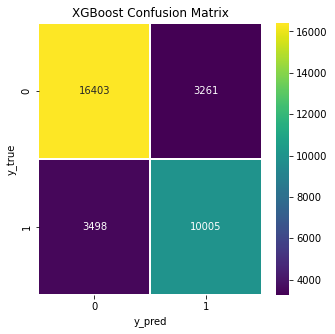

In [ ]:
cm = confusion_matrix(y_test, y_xgb_ht)

f, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(cm, annot = True, linewidths = 0.5, cmap = 'viridis', fmt = '.0f', ax = ax)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

Text(0.5, 0, 'False Positive Rate')

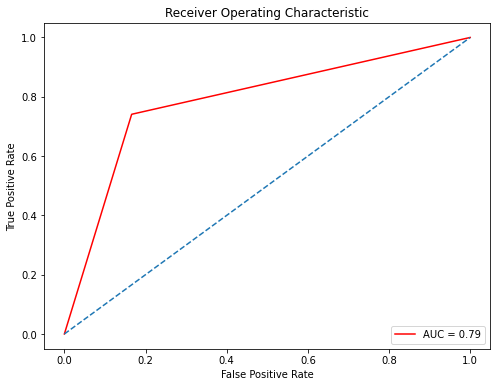

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_xgb_ht)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color='red', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### **LightGBM**

In [ ]:
param_lgbm = {
        'boosting_type' : ['gbdt', 'dart'],
        'n_estimators' : [50, 100, 150, 200, 250, 300],
        'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'num_leaves': sp_randint(6, 50),
        'min_child_samples': sp_randint(100, 500),
        'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
        'subsample': sp_uniform(loc = 0.2, scale = 0.8),
        'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
        'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
        'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
        'importance_type' : ['split', 'gain']
        }

lgbm_ht = RandomizedSearchCV(estimator = LGBMClassifier(), param_distributions = param_lgbm, cv = skf, n_iter = 25,
                             scoring = 'roc_auc', verbose = 5, return_train_score = True, random_state = 0)
lgbm_ht.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END boosting_type=gbdt, colsample_bytree=0.7557067709350109, importance_type=split, learning_rate=0.15, min_child_samples=351, min_child_weight=0.1, n_estimators=100, num_leaves=25, reg_alpha=7, reg_lambda=1, subsample=0.550069769010154;, score=(train=0.884, test=0.841) total time=   1.5s
[CV 2/5] END boosting_type=gbdt, colsample_bytree=0.7557067709350109, importance_type=split, learning_rate=0.15, min_child_samples=351, min_child_weight=0.1, n_estimators=100, num_leaves=25, reg_alpha=7, reg_lambda=1, subsample=0.550069769010154;, score=(train=0.877, test=0.868) total time=   1.5s
[CV 3/5] END boosting_type=gbdt, colsample_bytree=0.7557067709350109, importance_type=split, learning_rate=0.15, min_child_samples=351, min_child_weight=0.1, n_estimators=100, num_leaves=25, reg_alpha=7, reg_lambda=1, subsample=0.550069769010154;, score=(train=0.876, test=0.874) total time=   1.5s
[CV 4/5] END boosting_type=gbdt, colsampl

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(), n_iter=25,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f645fb63a60>,
                                        'importance_type': ['split', 'gain'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2, 0.25, 0.3],
                                        'min_c...
                                                             10000.0],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f645fb637c0>,
                         

In [ ]:
y_lgbm_ht = lgbm_ht.predict(X_test)
print(lgbm_ht.best_params_)
print(classification_report(y_test, y_lgbm_ht))
print(lgbm_ht.score(X_train, y_train), lgbm_ht.score(X_test, y_test))
print(roc_auc_score(y_test, y_lgbm_ht))

{'boosting_type': 'dart', 'colsample_bytree': 0.9351540130094033, 'importance_type': 'gain', 'learning_rate': 0.25, 'min_child_samples': 315, 'min_child_weight': 1e-05, 'n_estimators': 200, 'num_leaves': 46, 'reg_alpha': 5, 'reg_lambda': 1, 'subsample': 0.5753993391921937}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     19664
           1       0.75      0.74      0.75     13503

    accuracy                           0.80     33167
   macro avg       0.79      0.79      0.79     33167
weighted avg       0.80      0.80      0.80     33167

0.8836034771226131 0.8875476440849989
0.7865268123372157


## **Validation (New Test Datasets)**

In [ ]:
test_3 = getFeaturesChurn('2021-09-01', '2021-10-01', 1)
test_4 = getFeaturesChurn('2021-08-01', '2021-09-01', 1)
test_5 = getFeaturesChurn('2021-07-01', '2021-08-01', 1)

2021-09-01 - 2021-10-01
Rentang bulan : 1


/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


 => Q1 : 2021-09-01 00:00:00 - 2021-10-01 00:00:00
2021-08-01 - 2021-09-01
Rentang bulan : 1
 => Q1 : 2021-08-01 00:00:00 - 2021-09-01 00:00:00
2021-07-01 - 2021-08-01
Rentang bulan : 1
 => Q1 : 2021-07-01 00:00:00 - 2021-08-01 00:00:00


In [ ]:
#Feature Selection
test_3 = test_3[['customer_id', 'account_length', 'tot_time_spent_Q1', 'tot_add_to_cart_Q1', 'tot_promo_page_Q1', 'tot_add_promo_Q1', 'tot_amount_Q1',
                 'avg_amount_Q1', 'std_amount_Q1', 'avg_quantity_Q1', 'num_promo_code_used_Q1', 'num_0_shipment_fee_Q1', 'recency_Q1', 'fav_traffic_source_Q1',
                 'churn']]

test_4 = test_4[['customer_id', 'account_length', 'tot_time_spent_Q1', 'tot_add_to_cart_Q1', 'tot_promo_page_Q1', 'tot_add_promo_Q1', 'tot_amount_Q1',
                 'avg_amount_Q1', 'std_amount_Q1', 'avg_quantity_Q1', 'num_promo_code_used_Q1', 'num_0_shipment_fee_Q1', 'recency_Q1', 'fav_traffic_source_Q1',
                 'churn']]

test_5 = test_5[['customer_id', 'account_length', 'tot_time_spent_Q1', 'tot_add_to_cart_Q1', 'tot_promo_page_Q1', 'tot_add_promo_Q1', 'tot_amount_Q1',
                 'avg_amount_Q1', 'std_amount_Q1', 'avg_quantity_Q1', 'num_promo_code_used_Q1', 'num_0_shipment_fee_Q1', 'recency_Q1', 'fav_traffic_source_Q1',
                 'churn']]


#Handle null values
test_3 = test_3.fillna(0)
test_4 = test_4.fillna(0)
test_5 = test_5.fillna(0)


#Label Encoder
test_3['fav_traffic_source_Q1'] = fts_le.transform(test_3['fav_traffic_source_Q1'])
test_4['fav_traffic_source_Q1'] = fts_le.transform(test_4['fav_traffic_source_Q1'])
test_5['fav_traffic_source_Q1'] = fts_le.transform(test_5['fav_traffic_source_Q1'])


X_test_3 = test_3.drop(['customer_id', 'churn'], axis = 1)
y_test_3 = test_3['churn']

X_test_4 = test_4.drop(['customer_id', 'churn'], axis = 1)
y_test_4 = test_4['churn']

X_test_5 = test_5.drop(['customer_id', 'churn'], axis = 1)
y_test_5 = test_5['churn']

In [ ]:
y_xgb_ht_3 = xgb_ht.predict(X_test_3)
print(classification_report(y_test_3, y_xgb_ht_3))
print(roc_auc_score(y_test_3, y_xgb_ht_3))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      9185
           1       0.71      0.75      0.73      5979

    accuracy                           0.78     15164
   macro avg       0.77      0.78      0.78     15164
weighted avg       0.79      0.78      0.78     15164

0.7780977478514667


In [ ]:
y_xgb_ht_4 = xgb_ht.predict(X_test_4)
print(classification_report(y_test_4, y_xgb_ht_4))
print(roc_auc_score(y_test_4, y_xgb_ht_4))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      8836
           1       0.75      0.75      0.75      6159

    accuracy                           0.79     14995
   macro avg       0.79      0.79      0.79     14995
weighted avg       0.79      0.79      0.79     14995

0.7858162790473753


In [ ]:
y_xgb_ht_5 = xgb_ht.predict(X_test_5)
print(classification_report(y_test_5, y_xgb_ht_5))
print(roc_auc_score(y_test_5, y_xgb_ht_5))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      8527
           1       0.74      0.76      0.75      6408

    accuracy                           0.78     14935
   macro avg       0.78      0.78      0.78     14935
weighted avg       0.78      0.78      0.78     14935

0.7797457499692172


Ketika memprediksi data yang baru, hasil evaluasinya tidak menunjukan banyak perbedaan sehingga sepertinya model ini sudah cukup aman dan baik.

## **Feature Importance**

In [ ]:
xgb = XGBClassifier(tree_method = 'hist', reg_lambda = 0, reg_alpha = 0, n_estimators = 250, min_child_weight = 4, max_depth = 8, learning_rate = 0.15,
                    gamma = 5, booster = 'dart', base_score = 0.5)
xgb.fit(X_train, y_train)

XGBClassifier(booster='dart', gamma=5, learning_rate=0.15, max_depth=8,
              min_child_weight=4, n_estimators=250, reg_lambda=0,
              tree_method='hist')

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_, X_train.columns)), columns = ['Value', 'Features'])

plt.figure(figsize = (12, 6))
sns.barplot(x = 'Value', y = 'Features', data = feature_imp.sort_values(by = 'Value', ascending = False))
plt.title('XGBoost Features Importance')
plt.tight_layout()
plt.show()

AttributeError: ignored

Berikut adalah fitur yang penting bagi model LightGBM. Yang pertama adalah total session, kemudian recency, lalu total booking, add to cart, dan homepage.

# **Prediction**

In [ ]:
prediction = getFeaturesChurn('2022-07-01', '2022-08-01', 1)
prediction.info()

2022-07-01 - 2022-08-01
Rentang bulan : 1


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


 => Q1 : 2022-07-01 00:00:00 - 2022-08-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 2 to 99997
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    9974 non-null   int64  
 1   home_region                    9974 non-null   object 
 2   gender                         9974 non-null   object 
 3   device_type                    9974 non-null   object 
 4   age                            9974 non-null   int64  
 5   account_length                 9974 non-null   int64  
 6   tot_session_Q1                 9974 non-null   float64
 7   tot_time_spent_Q1              9974 non-null   float64
 8   pref_payment_method_Q1         9974 non-null   object 
 9   tot_order_Q1                   9974 non-null   float64
 10  tot_click_Q1                   9974 non-null   float64
 11  tot_homepage_Q1                9974 non-null   float64
 

In [ ]:
#Handle null values
prediction = prediction.fillna(0)

X_predict = prediction.copy()

#Label Encoder & One Hot Encoder
X_predict['gender'] = X_predict['gender'].map({'F' : 1, 'M' : 0})
X_predict['device_type'] = X_predict['device_type'].map({'Android' : 1, 'iOS' : 0})
X_predict['pref_traffic_source_Q1'] = X_predict['pref_traffic_source_Q1'].map({'MOBILE' : 1, 'WEB' : 0})
X_predict = pd.get_dummies(data = X_predict, columns = ['home_region', 'pref_payment_method_Q1'], drop_first = True)


X_predict = X_predict.drop(['customer_id', 'churn'], axis = 1)

In [ ]:
prediction['churn'] = lgbm_ht.predict(X_predict)
prediction[['churn_proba_0', 'churn_proba_1']] = lgbm_ht.predict_proba(X_predict)

In [ ]:
prediction.to_csv('prediction.csv', index = False)

In [ ]:
prediction = pd.read_csv('prediction.csv')

Text(0.5, 1.0, 'Churn Probability Distribution')

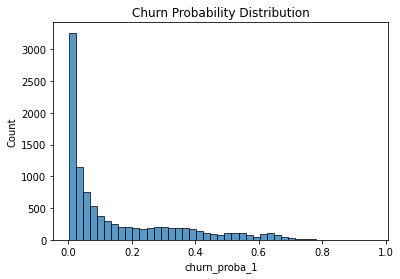

In [ ]:
sns.histplot(data = prediction, x = 'churn_proba_1')
plt.title('Churn Probability Distribution')

Banyak pelanggan yang tidak akan churn bulan depan.

Text(0.5, 1.0, 'Churn Probability Distribution by Gender')

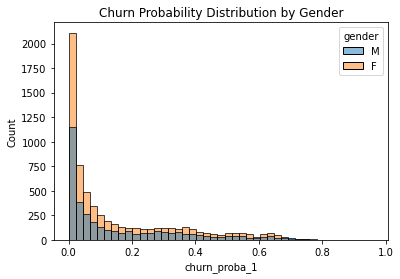

In [ ]:
sns.histplot(data = prediction, x = 'churn_proba_1', hue = 'gender')
plt.title('Churn Probability Distribution by Gender')

Text(0.5, 1.0, 'Churn Probability Distribution by Home Region')

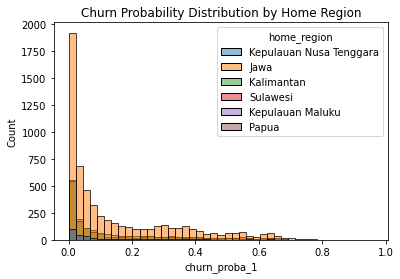

In [ ]:
sns.histplot(data = prediction, x = 'churn_proba_1', hue = 'home_region')
plt.title('Churn Probability Distribution by Home Region')

In [ ]:
# test = test.drop(['customer_id', 'churn'], axis = 1)

# # function predict (Baseline dan Hyperparameter Tuning -> belom dicoba di file ini)
def prediction_reports(prediction_data, clf_arr):

  clf_name = []
  churn = []
  not_churn = []

  for clf in clf_arr:
    if(str(clf) == 'RandomizedSearchCV'):
      print('RandomizedSearchCV')
      clf_name.append(clf.estimator)
      y_pred = pd.DataFrame(clf.predict(prediction_data))
      total = y_pred.count()[0]
      churn.append(y_pred[y_pred == 1].count()[0])
      not_churn.append(y_pred[y_pred == 0].count()[0])
    else:
      print(clf.__class__.__name__)
      clf_name.append(clf.__class__.__name__)
      y_pred = pd.DataFrame(clf.predict(prediction_data))
      total = y_pred.count()[0]
      churn.append(y_pred[y_pred == 1].count()[0])
      not_churn.append(y_pred[y_pred == 0].count()[0])

  #Dataframe
  models = pd.DataFrame({
    'Model': clf_name,
    'Total': total,
    'Churn': churn,
    'Not Churn': not_churn,
    '%Churn%': np.round((churn/total*100),2),
    '%Not Churn%': np.round((not_churn/total*100),2),
    })

  models['%Churn%']     = models['%Churn%'].apply(lambda x : (str(x) + '%'))
  models['%Not Churn%'] = models['%Not Churn%'].apply(lambda x : (str(x) + '%'))

  return models

# # function predict hasil RandomizedSearchCV (Hyperparameter Tuning -> udah dicoba & aman)
# def prediction_reports(prediction_data, clf_arr):

#   clf_name = []
#   churn = []
#   not_churn = []

#   for clf in clf_arr:
#     clf_name.append(clf.estimator)
#     y_pred = pd.DataFrame(clf.predict(prediction_data))
#     total = y_pred.count()[0]
#     churn.append(y_pred[y_pred == 1].count()[0])
#     not_churn.append(y_pred[y_pred == 0].count()[0])

#   #Dataframe
#   models = pd.DataFrame({
#     'Model': clf_name,
#     'Total': total,
#     'Churn': churn,
#     'Not Churn': not_churn,
#     '%Churn%': np.round((churn/total*100),2),
#     '%Not Churn%': np.round((not_churn/total*100),2),
#     })

#   models['%Churn%']     = models['%Churn%'].apply(lambda x : (str(x) + '%'))
#   models['%Not Churn%'] = models['%Not Churn%'].apply(lambda x : (str(x) + '%'))

#   return models


# X_predict_kbest_scaled = scaler.transform(test)
prediction_reports(X_predict, models_arr)


LogisticRegression
GaussianNB
MLPClassifier
KNeighborsClassifier
DecisionTreeClassifier
AdaBoostClassifier
RandomForestClassifier
GradientBoostingClassifier
XGBClassifier
LGBMClassifier


,Model,Total,Churn,Not Churn,%Churn%,%Not Churn%
0,LogisticRegression,9974,3766,6208,37.76%,62.24%
1,GaussianNB,9974,5854,4120,58.69%,41.31%
2,MLPClassifier,9974,8,9966,0.08%,99.92%
3,KNeighborsClassifier,9974,2689,7285,26.96%,73.04%
4,DecisionTreeClassifier,9974,1695,8279,16.99%,83.01%
5,AdaBoostClassifier,9974,1013,8961,10.16%,89.84%
6,RandomForestClassifier,9974,839,9135,8.41%,91.59%
7,GradientBoostingClassifier,9974,833,9141,8.35%,91.65%
8,XGBClassifier,9974,897,9077,8.99%,91.01%
9,LGBMClassifier,9974,823,9151,8.25%,91.75%


In [ ]:
auc_arr = []
auc_name = []

auc_arr.append(roc_auc_score(y_test, y_lr_ht))
auc_name.append(lr_ht.estimator)

auc_arr.append(roc_auc_score(y_test, y_nb_ht))
auc_name.append(nb_ht.estimator)

auc_arr.append(roc_auc_score(y_test, y_gb_ht))
auc_name.append(gb_ht.estimator)


auc_arr.append(roc_auc_score(y_test, y_lgbm_ht))
auc_name.append(lgbm_ht.estimator)


auc_arr.append(roc_auc_score(y_test, y_xgb_ht))
auc_name.append(xgb_ht.estimator)
auc_df = pd.DataFrame({
    'Nama' : auc_name,
    'ROC AUC' : auc_arr,
})
auc_df

# **Customer Segmentation**

In [ ]:
#Recency
recency = df[df['payment_status'] == 'Success'].groupby(['customer_id'])['created_at'].max().reset_index().rename(
    columns = {'created_at' : 'last_order_date'})
recency['Recency'] = (pd.to_datetime(df['created_at'].max()) - pd.to_datetime(recency['last_order_date'])).astype('timedelta64[D]')
recency = recency.drop(['last_order_date'], axis = 1)

#Frequency
frequency = df[df['payment_status'] == 'Success'].groupby(['customer_id'])['created_at'].count().reset_index().rename(
    columns = {'created_at' : 'Frequency'})

#Monetary
monetary = transactions[transactions['payment_status'] == 'Success'].groupby(['customer_id'])['total_amount'].sum().reset_index().rename(
    columns = {'total_amount' : 'Monetary'})

#Merge
rfm = recency.merge(right = frequency, how = 'outer', on = 'customer_id').merge(right = monetary, how = 'outer', on = 'customer_id')

#Calculate RFM score
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'], 5, labels = [1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

#Create segment map
segment_map= {
    r'111|112|121|131|141|151': 'Lost Customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating Customers',
    r'155|154|144|214|215|115|114|113': 'Can\'t Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(segment_map, regex = True)

df_rfm = rfm[['Segment', 'Recency', 'Frequency', 'Monetary']].groupby('Segment').agg(['mean','median', 'min', 'max', 'count'])

# Tambah kolom ratio
df_rfm['ratio']= (100*df_rfm['Monetary']['count']/df_rfm['Monetary']['count'].sum()).round(3)
df_rfm

Recency                                Frequency  \
                              mean  median    min     max  count       mean   
Segment                                                                       
About To Sleep          185.678808   147.0   73.0   468.0    604   2.112583   
At Risk                 420.398669   273.0  175.0  2198.0   1653  13.379915   
Can't Lose Them         959.861423   829.0  220.0  2188.0    267   4.086142   
Champions                26.179930    24.0    0.0    72.0  11938  73.128665   
Hibernating customers   347.093933   293.0   73.0  2217.0  12115   4.255138   
Lost customers         1109.840627  1000.0  470.0  2221.0   7404   1.294165   
Loyal                    80.222902    77.0    0.0   174.0   6209  26.924464   
Need Attention           85.553991    82.0    0.0   174.0   1704  12.531690   
New Customers            73.403685    61.0    0.0   174.0   2388   2.021357   
Potential Loyalist       78.580217    73.0    0.0   174.0   5348   8.755797   
Promising                24.751634    16.0    0.0   174.0    612   3.638889   

                                                  Monetary              \
                      median min  max  count          mean      median   
Segment                                                                  
About To Sleep           2.0   1    4    604  1.045299e+06    706220.5   
At Risk                 12.0   3  583   1653  5.798641e+06   5280255.0   
Can't Lose Them          2.0   1   32    267  3.599598e+06   2875523.0   
Champions               54.0  14  807  11938  2.745751e+07  20458482.5   
Hibernating customers    4.0   1   13  12115  1.403959e+06   1159509.0   
Lost customers           1.0   1    4   7404  4.126273e+05    328407.0   
Loyal                   22.0   7  673   6209  1.001973e+07   8177384.0   
Need Attention          13.0   3   22   1704  5.448782e+06   5078369.0   
New Customers            2.0   1    5   2388  5.743684e+05    433170.5   
Potential Loyalist       9.0   3   13   5348  2.987963e+06   2926617.0   
Promising                4.0   1    5    612  1.829122e+06   1363280.5   

                                                   ratio  
                           min        max  count          
Segment                                                   
About To Sleep          281996    4797507    604   1.202  
At Risk                1830595  201361586   1653   3.290  
Can't Lose Them        1829282   10700555    267   0.531  
Champions              4811351  320061849  11938  23.761  
Hibernating customers    35761    4802105  12115  24.113  
Lost customers           27450    1815497   7404  14.737  
Loyal                  3031028  238844440   6209  12.358  
Need Attention         2725090   15018778   1704   3.392  
New Customers            45204    1810618   2388   4.753  
Potential Loyalist      942181    4803908   5348  10.644  
Promising               362760   13202391    612   1.218

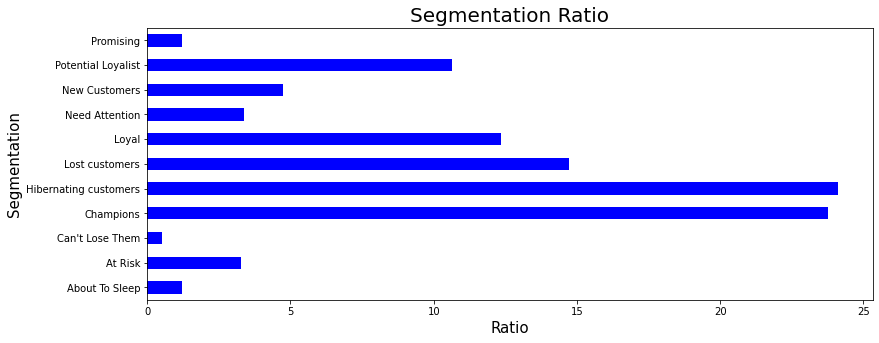

In [ ]:
# Plot segmentation ratio horizontal
df_rfm['ratio'].plot(kind = 'barh', figsize = (13, 5), color = 'blue')
plt.title('Segmentation Ratio', fontsize = 20)
plt.xlabel('Ratio', fontsize = 15)
plt.ylabel('Segmentation', fontsize = 15)
plt.show()

Text(0.5, 0.98, 'Recency and Frequency Grid')

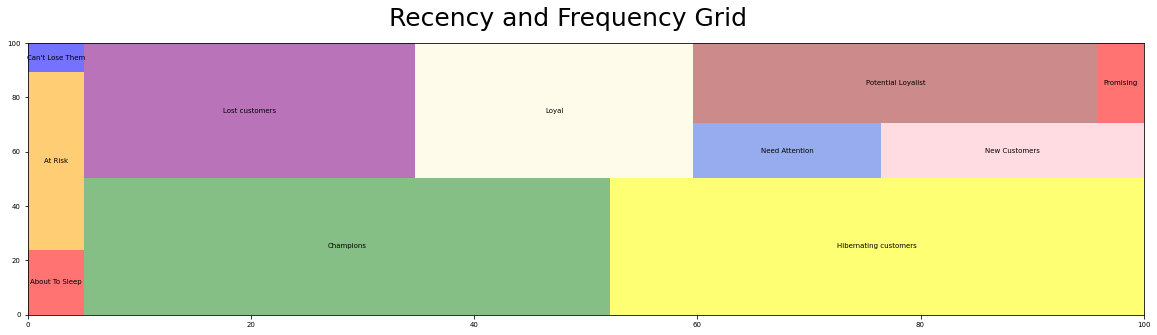

In [ ]:
plt.figure(figsize = (20, 5))
plt.rc('font', size = 7)
squarify.plot(sizes = df_rfm["Recency"]["count"], label = df_rfm.index,
              color = ["red","orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue", "pink", "brown"], alpha =.55)
plt.suptitle("Recency and Frequency Grid", fontsize = 25)

In [ ]:
rfm['Segment'].value_counts()

Hibernating customers    12115
Champions                11938
Lost customers            7404
Loyal                     6209
Potential Loyalist        5348
New Customers             2388
Need Attention            1704
At Risk                   1653
Promising                  612
About To Sleep             604
Can't Lose Them            267
Name: Segment, dtype: int64

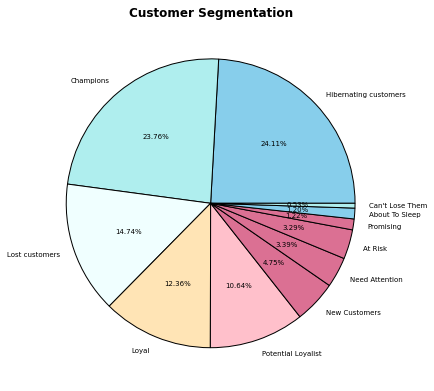

In [ ]:
plt.figure(figsize = (6, 6))
plt.pie(rfm['Segment'].value_counts(), labels = rfm['Segment'].value_counts().index, autopct = '%1.2f%%', wedgeprops = {'edgecolor' : 'black'}, colors = ['skyblue', 'paleturquoise', 'azure', 'moccasin', 'pink', 'palevioletred', 'palevioletred', 'palevioletred', 'palevioletred'])
plt.title('Customer Segmentation', fontweight = 'bold', fontdict = {'fontsize' : 12})
plt.tight_layout()

# **RRRR**